```
This file is part of sscx-connectome-manipulations.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Figures related to SSCx connectome manipulations

## Part I: Structural figures

We demonstrate the applicability of our [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) framework by manipulating the connectome of a detailed model of the rat somatosensory cortex (SSCx) and quantifying functional changes through network simulations.

ℹ️ This notebook reproduces the structural figures from [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) (Python venv)
- [NeuroM](https://github.com/BlueBrain/NeuroM) (Python venv)
- [SSCx network model](https://doi.org/10.5281/zenodo.8026353)
- Manipulated SSCx circuits with rewired connectomes (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to recompute)
- Results from structural comparison (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to recompute)
- Results from model order validation (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to recompute)

In [62]:
import colorsys
import matplotlib.pyplot as plt
import neurom as nm
import numpy as np
import os
import pickle

from bluepysnap import Circuit
from connectome_manipulator.model_building import model_types
from connectome_manipulator.connectome_comparison.structural_comparator import results_diff
from matplotlib import colors
from scipy.stats import multivariate_normal

In [2]:
# Set and create output figures folder
figs_path = './figs_struct'
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

In [15]:
def ordinal_nr(nr):
    if nr == 1:
        return '1st'
    elif nr == 2:
        return '2nd'
    elif nr == 3:
        return '3rd'
    else:
        return f'{nr}th'


def upper(txt, first_n=None):
    if first_n is None:
        return txt.upper()
    else:
        return txt[:first_n].upper() + txt[first_n:]


def plot_struct_res(struct_dict, res_sel, fig_title, group_by, plot_range=[None, None], cmap='hot_r', colorbar=True, new_fig=True, fig_size=(4, 3), x_rot=False, figs_path=None, fn_spec="", cbar_specs={}):
    """Plot structural results."""
    res_dict = struct_dict[res_sel]
    common_dict = struct_dict['common']

    if new_fig:
        plt.figure(figsize=fig_size)

    if plot_range is None:
        plot_range = np.nanmax(np.abs(res_dict['data']))
    if np.isscalar(plot_range):  # +/- symmetric
        vmin = -np.abs(plot_range)
        vmax = np.abs(plot_range)
    else:
        vmin = np.nanmin(res_dict['data']) if plot_range[0] is None else plot_range[0]
        vmax = np.nanmax(res_dict['data']) if plot_range[-1] is None else plot_range[-1]

    print(f'{res_dict["unit"]} data range: [{np.nanmin(res_dict["data"]):.3f}, {np.nanmax(res_dict["data"]):.3f}]')
    print(f'{res_dict["unit"]} plot range: [{vmin:.3f}, {vmax:.3f}]')

    plt.imshow(res_dict['data'], interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    if len(fig_title) > 0:
        plt.title(fig_title, fontweight='bold')
    plt.xlabel(f'Post-synaptic {group_by}')
    plt.ylabel(f'Pre-synaptic {group_by}')
    plt.xticks(range(len(common_dict['tgt_group_values'])), common_dict['tgt_group_values'], rotation=90 if x_rot else 0)
    plt.yticks(range(len(common_dict['src_group_values'])), common_dict['src_group_values'])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['bottom'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)
    if colorbar:
        h_cb = plt.colorbar(**cbar_specs)
        h_cb.set_label(label=res_dict['unit'], size=None)
        h_cb.ax.tick_params(labelsize=None)

    if new_fig:
        plt.tight_layout()
        if figs_path is not None:
            is_diff = '_diff' if -vmin == vmax else ''
            fn = f'struct_res__{fn_spec}{fig_title.replace(" ", "")}_{res_sel}_by_{group_by}{is_diff}'
            plt.savefig(os.path.join(figs_path, f'{fn}.png'), dpi=600)
            plt.savefig(os.path.join(figs_path, f'{fn}.svg'), dpi=600)
        plt.show()


def plot_struct_res_scatter(struct_dict1, struct_dicts2, res_sel, fig_title, ax_labels, group_by, err_sel=None, plot_range=[None, None], plot_specs={}, colors=None, lgd_labels=None, lgd_specs={}, new_fig=True, fig_size=(4, 3), fn_spec="", figs_path=None):
    """Plot structural results as scatter plot."""
    if not isinstance(struct_dicts2, list):
        struct_dicts2 = [struct_dicts2]
    if not isinstance(colors, list):
        colors = [colors] * len(struct_dicts2)
    else:
        assert len(struct_dicts2) == len(colors), 'ERROR: Colors mismatch!'
    if lgd_labels is not None:
        assert isinstance(lgd_labels, list) and len(struct_dicts2) == len(lgd_labels), 'ERROR: Legend mismatch!'

    res_dict1 = struct_dict1[res_sel]
    res_dicts2 = [_sdict2[res_sel] for _sdict2 in struct_dicts2]
    for _res in res_dicts2:
        assert res_dict1["unit"] == _res["unit"], 'ERROR: Unit mismatch!'
    common_dict = struct_dict1['common']
    for _sdict2 in struct_dicts2:
        for _k in common_dict.keys():
            assert np.array_equal(common_dict[_k], _sdict2['common'][_k]), f'ERROR: Common dict "{_k}" mismatch!'
    if err_sel is None:
        err1 = None
        errs2 = [None] * len(struct_dicts2)
    else:
        err1 = struct_dict1[err_sel]['data'].flatten()
        errs2 = [_sdict2[err_sel]['data'].flatten() for _sdict2 in struct_dicts2]

    if new_fig:
        plt.figure(figsize=fig_size)

    if not isinstance(plot_range, list):
        plot_range = [0, plot_range]

    vmin = np.nanmin(res_dict1['data']) if plot_range[0] is None else plot_range[0]
    vmax = np.nanmax(res_dict1['data']) if plot_range[-1] is None else plot_range[-1]

    print(f'{res_dict1["unit"]} data range: [{np.nanmin(res_dict1["data"]):.3f}, {np.nanmax(res_dict1["data"]):.3f}]')
    print(f'{res_dict1["unit"]} plot range: [{vmin:.3f}, {vmax:.3f}]')
    print(f'{len(res_dict1["data"].flatten())} data points')

    alpha = plot_specs.pop('alpha', 1.0)  # Remove alpha from plot specs...

    h_plt = []
    for _res2, _err2, _col, _lbl in zip(res_dicts2, errs2, colors, [None] * len(res_dicts2) if lgd_labels is None else lgd_labels):
        col_dict = dict(color=_col) if _col is not None else {}
        h_plt.append(plt.errorbar(res_dict1["data"].flatten(), _res2['data'].flatten(), xerr=err1, yerr=_err2, **plot_specs, **col_dict, label=_lbl, clip_on=False))
    plt.plot([vmin, vmax], [vmin, vmax], color='grey', lw=1, zorder=0, clip_on=False)
    plt.axis('image')
    plt.xlim([vmin, vmax])
    plt.ylim([vmin, vmax])
    plt.title(fig_title, fontweight='bold')
    plt.xlabel(f'{ax_labels[0]}')
    plt.ylabel(f'{ax_labels[1]}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().set_xticks(plt.gca().get_yticks())

    if lgd_labels is not None:
        plt.legend(**lgd_specs)

    if alpha < 1.0:  # ... set alpha AFTER legend (so that legend will be show fully opaque)
        for _h in h_plt:
            for _ch in _h.get_children():
                _ch.set_alpha(alpha)

    if new_fig:
        plt.tight_layout()
        plt.gca().set_xticks(plt.gca().get_yticks())
        if figs_path is not None:
            fn = f'struct_res_scatter__{fn_spec}{res_sel}_by_{group_by}'
            plt.savefig(os.path.join(figs_path, f'{fn}.png'), dpi=600)
            plt.savefig(os.path.join(figs_path, f'{fn}.svg'), dpi=600)
        plt.show()

## Interneuron rewiring

Results figures related to VIP+ interneuron rewiring according to target specificity trends from MICrONS data.

### Structural comparison

ℹ️ Set results path below pointing to location of structural comparison results

In [42]:
# Paths to structural comparison results
struct_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/structural_comparator/SSCx-HexO1-Release/data'

_SSCx network model:_ Download and extract `O1_data_physiology_withfix.xz` and set path accordingly:

In [43]:
# Path to SSCx network model
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json'  # Released 210K nbS1 (SSCx HexO1) physiology circuit from [Isbister et al. 2023]

#### Adjacency matrix
- hex0 adjacency matrix from VIP+ (BTC/SBC) to all, grouped by E/I pathways
- Optional: Subsampling of neurons for better visualization

In [44]:
c = Circuit(circuit_config)
nodes = c.nodes['S1nonbarrel_neurons']
edges = c.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']
node_set = 'hex0'
src_types = ['L23_BTC', 'L23_SBC', 'L4_BTC', 'L4_SBC', 'L5_BTC', 'L5_SBC', 'L6_BTC', 'L6_SBC']
nclass_all = nodes.get(node_set, ['synapse_class', 'layer', 'mtype'])
nids_all = nclass_all.index.values
nclass_src = nclass_all[np.isin(nclass_all['mtype'], src_types)]
nids_src = nclass_src.index.values
nids_exc = nclass_all[nclass_all['synapse_class'] == 'EXC'].index.values
nids_inh = nclass_all[nclass_all['synapse_class'] == 'INH'].index.values
nclass_all['sort_idx'] = range(nclass_all.shape[0])
nclass_src['sort_idx'] = range(nclass_src.shape[0])
sort_idx_all = nclass_all.sort_values(by=['synapse_class', 'layer'])['sort_idx'].values  # Sort by synapse class & layer
sort_idx_src = nclass_src.sort_values(by=['synapse_class', 'layer'])['sort_idx'].values  # Sort by synapse class & layer
print(f'INFO: {len(nids_all)} "{node_set}" cells, {len(nids_exc)} EXC, {len(nids_inh)} INH')
print(f'INFO: {len(nids_src)} "{node_set}" input cells of types {src_types}')

# Check EXC/INH separation
assert np.all(np.isin(nids_all[sort_idx_all][:len(nids_exc)], nids_exc)), 'ERROR: EXC sort error!'
assert np.all(np.isin(nids_all[sort_idx_all][len(nids_exc):], nids_inh)), 'ERROR: INH sort error!'

INFO: 30190 "hex0" cells, 26787 EXC, 3403 INH
INFO: 530 "hex0" input cells of types ['L23_BTC', 'L23_SBC', 'L4_BTC', 'L4_SBC', 'L5_BTC', 'L5_SBC', 'L6_BTC', 'L6_SBC']


/nvme/pokorny/2244204/ipykernel_12882/2145649245.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nclass_src['sort_idx'] = range(nclass_src.shape[0])


In [45]:
struct_files = [os.path.join(struct_path, 'Orig_AdjacencyHex0.pickle'),
                os.path.join(struct_path, 'Manip_AdjacencyHex0.pickle')]

In [46]:
# Load adj. matrices and compute difference
adj_mats = []
syn_mats = []
for res_file in struct_files:
    with open(res_file, 'rb') as f:
        res_dict = pickle.load(f)

    assert np.array_equal(res_dict['common']['src_gids'], nids_src), 'ERROR: Source node IDs mismatch!'
    assert np.array_equal(res_dict['common']['tgt_gids'], nids_all), 'ERROR: Target node IDs mismatch!'

    adj_mat = res_dict['adj']['data']
    adj_mat = adj_mat[:, sort_idx_all][sort_idx_src, :]  # Re-sort adj. matrix
    syn_mat = res_dict['adj_cnt']['data']
    syn_mat = syn_mat[:, sort_idx_all][sort_idx_src, :]  # Re-sort syn. matrix

    adj_mats.append(adj_mat)
    syn_mats.append(syn_mat)

adj_diff = adj_mats[1].astype(int) - adj_mats[0].astype(int)
syn_diff = syn_mats[1].astype(int) - syn_mats[0].astype(int)

In [47]:
for adj_mat, syn_mat, nm in zip(adj_mats, syn_mats, ['Original', 'Rewired']):
    print(f'{nm}: {adj_mat.count_nonzero()} connections, {syn_mat.sum()} synapses')
print(f'DIFF: {adj_diff.count_nonzero()} connections changed, {np.sum(adj_diff == 1)} added, {np.sum(adj_diff == -1)} deleted')

Original: 90200 connections, 1276686 synapses
Rewired: 733742 connections, 1593595 synapses
DIFF: 754276 connections changed, 698909 added, 55367 deleted


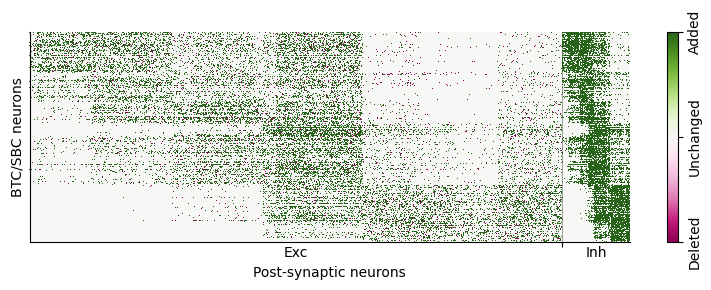

In [48]:
# Plot adjacency difference
sub_pct = 10  # Subsampled percentage of connections to display
cmap = 'PiYG'

def get_COO_data(mat):
    """Returns (non-empty) matrix elements in COOrdinate format (row/col/data)"""
    mat = mat.tocoo()
    return mat.row, mat.col, mat.data

rows, cols, color_idx = get_COO_data(adj_diff)

plt.figure(figsize=(8, 3))
sub_sel = np.random.choice(len(color_idx), np.round(len(color_idx) * sub_pct / 100).astype(int), replace=False)
plt.scatter(cols[sub_sel], rows[sub_sel], marker=',', s=2.5 / sub_pct, edgecolors='none', alpha=1.0, c=color_idx[sub_sel], cmap=cmap, vmin=-1, vmax=1, clip_on=False)
plt.axis('tight')
plt.xlim(-0.5, adj_diff.shape[1] - 0.5)
plt.ylim(-0.5, adj_diff.shape[0] - 0.5)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(plt.colormaps[cmap](0.5))  # Set background to middle of colormap

grid_loc = len(nids_exc) - 0.5
plt.xticks([grid_loc], labels=[], minor=False)
plt.plot(np.full(2, grid_loc), plt.ylim(), '-', color='grey', lw=0.5, zorder=0)
plt.yticks([])

EI_ticks = [len(nids_exc) / 2 - 0.5, len(nids_exc) + len(nids_inh) / 2 - 0.5]
plt.xticks(EI_ticks, labels=['Exc', 'Inh'], minor=True)
plt.gca().tick_params(which='minor', length=0)

plt.xlabel('Post-synaptic neurons')
plt.ylabel('BTC/SBC neurons')
# plt.title(f'Interneurons rewired', fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

h_cb = plt.colorbar()
h_cb.set_ticks([-1, 0, 1], labels=['Deleted', 'Unchanged', 'Added'], rotation=90, va='center')

plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'adj_diff_interneurons_rewired_subpct{sub_pct}.png'), dpi=600)
    # HUGE FILE SIZE # plt.savefig(os.path.join(figs_path, f'adj_diff_interneurons_rewired_subpct{sub_pct}.svg'), dpi=600)
plt.show()


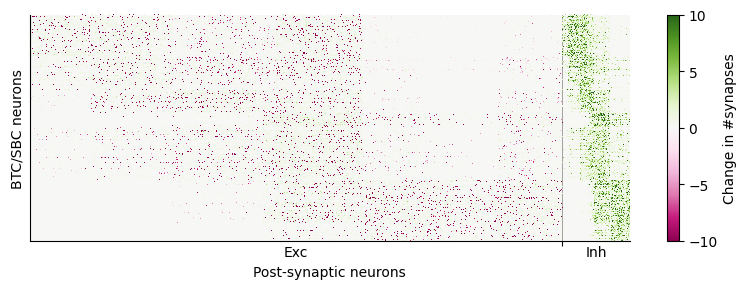

In [49]:
# Plot #syn/conn difference
sub_pct = 10  # Subsampled percentage of connections to display
cmap = 'PiYG'

def get_COO_data(mat):
    """Returns (non-empty) matrix elements in COOrdinate format (row/col/data)"""
    mat = mat.tocoo()
    return mat.row, mat.col, mat.data

rows, cols, color_idx = get_COO_data(syn_diff)
vrange = np.percentile(np.abs(color_idx), 90)

plt.figure(figsize=(8, 3))
sub_sel = np.random.choice(len(color_idx), np.round(len(color_idx) * sub_pct / 100).astype(int), replace=False)
plt.scatter(cols[sub_sel], rows[sub_sel], marker=',', s=2.5 / sub_pct, edgecolors='none', alpha=1.0, c=color_idx[sub_sel], cmap=cmap, vmin=-vrange, vmax=vrange, clip_on=False)
plt.axis('tight')
plt.xlim(-0.5, adj_diff.shape[1] - 0.5)
plt.ylim(-0.5, adj_diff.shape[0] - 0.5)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(plt.colormaps[cmap](0.5))  # Set background to middle of colormap

grid_loc = len(nids_exc) - 0.5
plt.xticks([grid_loc], labels=[], minor=False)
plt.plot(np.full(2, grid_loc), plt.ylim(), '-', color='grey', lw=0.5, zorder=0)
plt.yticks([])

EI_ticks = [len(nids_exc) / 2 - 0.5, len(nids_exc) + len(nids_inh) / 2 - 0.5]
plt.xticks(EI_ticks, labels=['Exc', 'Inh'], minor=True)
plt.gca().tick_params(which='minor', length=0)

plt.xlabel('Post-synaptic neurons')
plt.ylabel('BTC/SBC neurons')
# plt.title(f'Interneurons rewired', fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

h_cb = plt.colorbar(label='Change in #synapses')
cb_steps = 5
h_cb.set_ticks(np.arange(-np.floor(vrange / cb_steps) * cb_steps, np.floor(vrange / cb_steps) * cb_steps + 0.1, cb_steps))

plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'syn_diff_interneurons_rewired_subpct{sub_pct}.png'), dpi=600)
    # HUGE FILE SIZE # plt.savefig(os.path.join(figs_path, f'syn_diff_interneurons_rewired_subpct{sub_pct}.svg'), dpi=600)
plt.show()


#### Connectivity by m-type

- Connection probability and #syn/conn
- Grouped by m-type

In [50]:
# Structural comparison by m-type
struct_files = [os.path.join(struct_path, 'Orig_ConnPerMTypeHex0.pickle'),
                os.path.join(struct_path, 'Manip_ConnPerMTypeHex0.pickle')]
plot_names = ['Original',
              'Rewired']

In [51]:
# Load results for structural comparison
res_dicts = []
for fn in struct_files:
    with open(fn, 'rb') as f:
        res_dict = pickle.load(f)
    # mask = res_dict['conn_prob']['data'] == 0.0  # For plotting, set pathways with conn. prob. 0.0 to NaN
    # rm_zeros(res_dict, mask)
    res_dicts.append(res_dict)

Conn. prob. (%) data range: [0.000, 2.083]
Conn. prob. (%) plot range: [0.000, 2.000]


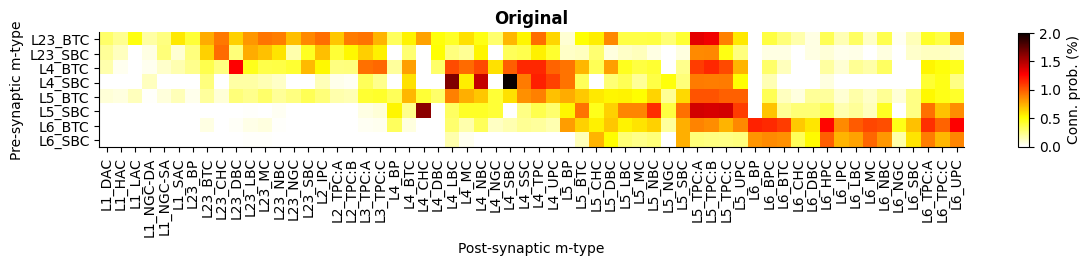

Mean #syn/conn data range: [0.000, 26.881]
Mean #syn/conn plot range: [0.000, 30.000]


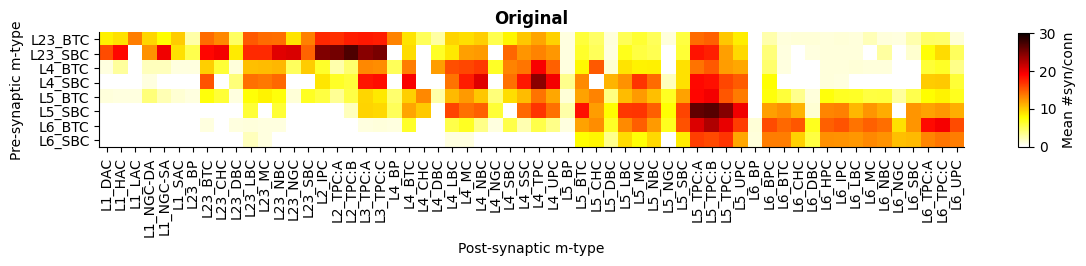

Conn. prob. (%) data range: [0.000, 79.167]
Conn. prob. (%) plot range: [0.000, 80.000]


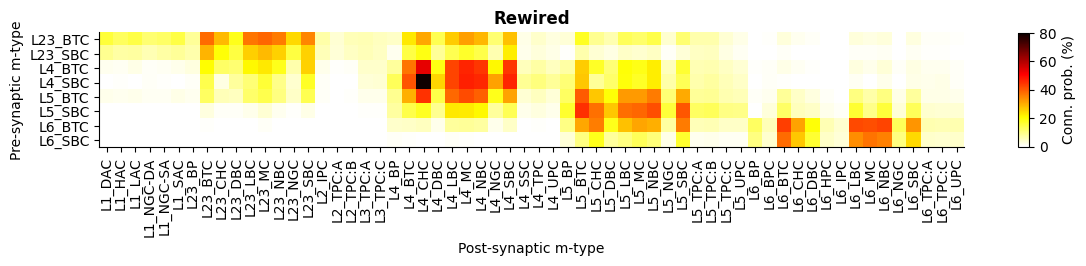

Mean #syn/conn data range: [0.000, 7.149]
Mean #syn/conn plot range: [0.000, 8.000]


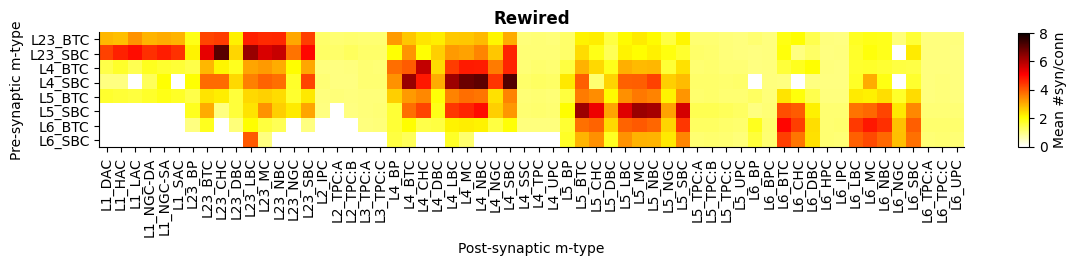

In [52]:
# Plot conn. prob. per layer
cmaps = ['hot_r'] * 2  # Redefine color map
plot_range_prob = [[0, 2.0], [0, 80.0]]
plot_range_nsyn = [[0, 30.0], [0, 8.0]]
for _idx in range(len(res_dicts)):
    plot_struct_res(res_dicts[_idx], 'conn_prob', plot_names[_idx], 'm-type', plot_range=plot_range_prob[_idx], cmap=cmaps[_idx], colorbar=True, new_fig=True, x_rot=True, fig_size=(12, 3), figs_path=figs_path, fn_spec="IntRew_", cbar_specs=dict(shrink=0.5, aspect=10))
    plot_struct_res(res_dicts[_idx], 'nsyn_conn', plot_names[_idx], 'm-type', plot_range=plot_range_nsyn[_idx], cmap=cmaps[_idx], colorbar=True, new_fig=True, x_rot=True, fig_size=(12, 3), figs_path=figs_path, fn_spec="IntRew_", cbar_specs=dict(shrink=0.5, aspect=10))

Conn. prob. (%) data range: [0.000, 0.000]
Conn. prob. (%) plot range: [-80.000, 80.000]


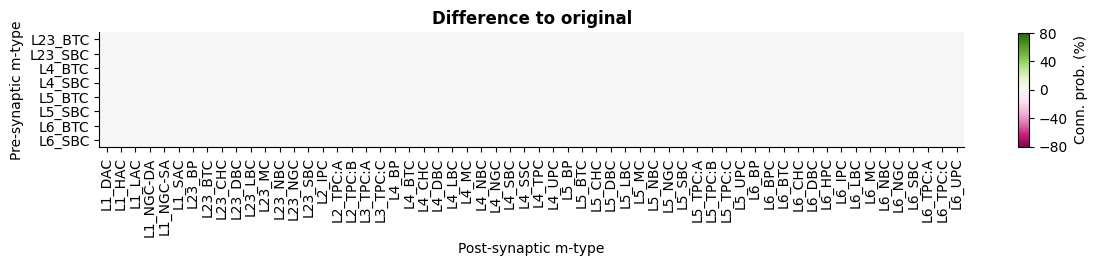

Mean #syn/conn data range: [0.000, 0.000]
Mean #syn/conn plot range: [-30.000, 30.000]


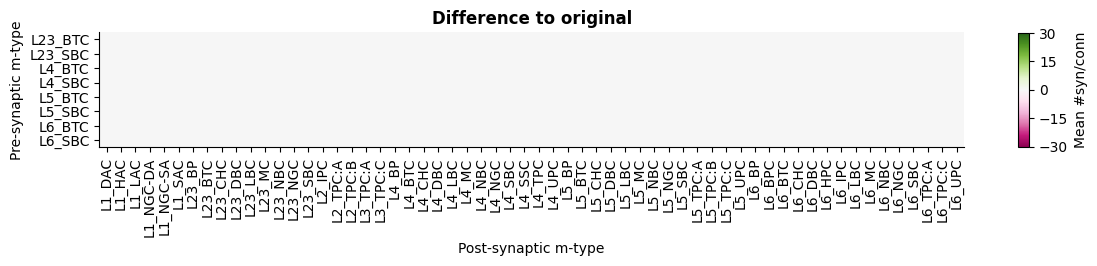

Conn. prob. (%) data range: [-0.365, 79.167]
Conn. prob. (%) plot range: [-80.000, 80.000]


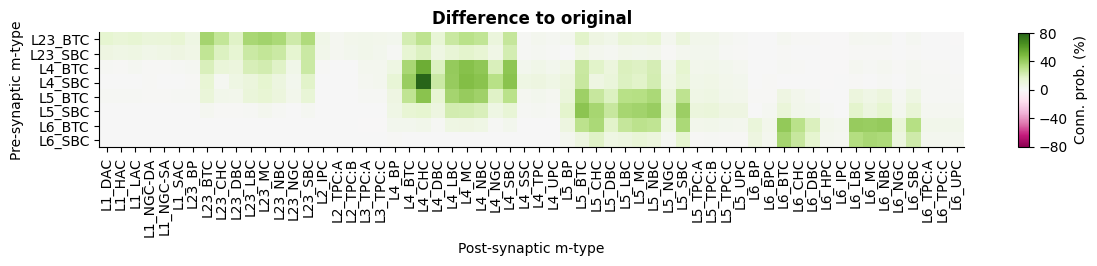

Mean #syn/conn data range: [-25.596, 5.800]
Mean #syn/conn plot range: [-30.000, 30.000]


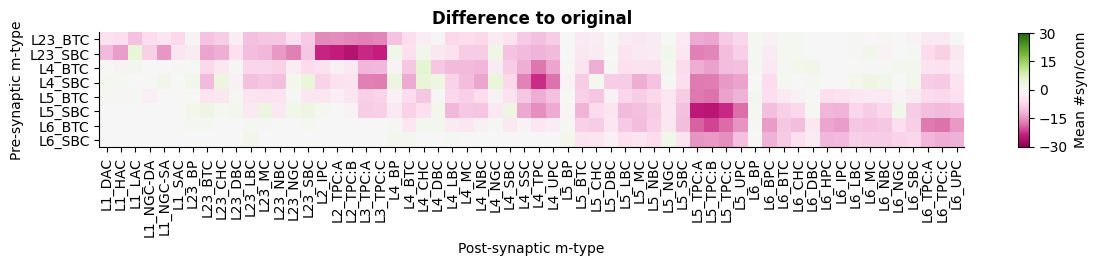

In [53]:
# Plot conn. prob. & nsyn/conn difference per layer
plot_range_prob = 80.0
plot_range_nsyn = 30.0
diff_cmap = 'PiYG'
for _idx in range(len(res_dicts)):
    plot_struct_res(results_diff(res_dicts[0], res_dicts[_idx]), 'conn_prob', 'Difference to original', 'm-type', plot_range=plot_range_prob, cmap=diff_cmap, colorbar=True, new_fig=True, x_rot=True, fig_size=(12, 3), figs_path=figs_path, fn_spec="IntRew_", cbar_specs=dict(shrink=0.5, aspect=10, ticks=range(-80, 81, 40)))
    plot_struct_res(results_diff(res_dicts[0], res_dicts[_idx]), 'nsyn_conn', 'Difference to original', 'm-type', plot_range=plot_range_nsyn, cmap=diff_cmap, colorbar=True, new_fig=True, x_rot=True, fig_size=(12, 3), figs_path=figs_path, fn_spec="IntRew_", cbar_specs=dict(shrink=0.5, aspect=10, ticks=range(-30, 31, 15)))

In [54]:
# Split res dict by EXC/INH m-type
exc_inh_mtypes = nclass_all.groupby('mtype').first()['synapse_class']
exc_mtypes = list(exc_inh_mtypes[exc_inh_mtypes == 'EXC'].index)
inh_mtypes = list(exc_inh_mtypes[exc_inh_mtypes == 'INH'].index)

def split_res_dicts(res_dicts, prop, split_classes, split_df):
    res_dicts_split = []
    for split_class in split_classes:
        split_dicts = []
        for rdict in res_dicts:
            assert np.array_equal(rdict['common']['tgt_group_values'], split_df.index), 'ERROR: Split DataFrame mismatch!'
            split_dict = {}
            split_dict['common'] = {'src_group_values': rdict['common']['src_group_values'],
                                    'tgt_group_values': rdict['common']['tgt_group_values'][split_df == split_class]}
            split_dict[prop] = {'data': rdict[prop]['data'][:, split_df == split_class],
                                       'unit': rdict[prop]['unit']}
            split_dict[prop + '_std'] = {'data': rdict[prop + '_std']['data'][:, split_df == split_class],
                                           'unit': rdict[prop + '_std']['unit']}
            split_dicts.append(split_dict)
        res_dicts_split.append(split_dicts)
    return res_dicts_split

split_classes = ['EXC', 'INH']
res_dicts_split = split_res_dicts(res_dicts, 'nsyn_conn', split_classes, exc_inh_mtypes)

Mean #syn/conn data range: [0.000, 26.881]
Mean #syn/conn plot range: [0.000, 40.000]
144 data points
Mean #syn/conn data range: [0.000, 20.667]
Mean #syn/conn plot range: [0.000, 40.000]
336 data points


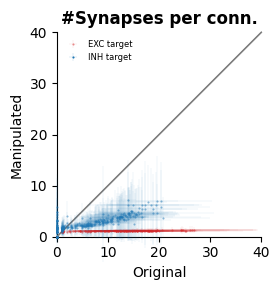

In [55]:
# nsyn/conn scatter plot (divided by target class)
split_colors = ["tab:red", "tab:blue"]

plt.figure(figsize=(3, 3))
for rdicts, split_class, split_col in zip(res_dicts_split, split_classes, split_colors):
    plot_struct_res_scatter(rdicts[0], rdicts[1], 'nsyn_conn', '#Synapses per conn.', ['Original', 'Manipulated'], 'm-type', err_sel='nsyn_conn_std', plot_range=[0, 40], plot_specs=dict(fmt='.', alpha=0.5, lw=0.1, ms=3, markeredgecolor='none'), colors=split_col, lgd_labels=[split_class + ' target'], lgd_specs=dict(frameon=False, loc='upper left', fontsize=6), new_fig=False)
plt.gca().spines['left'].set_zorder(-1000)
plt.gca().spines['bottom'].set_zorder(-1000)
plt.tight_layout()
plt.gca().set_xticks(plt.gca().get_yticks())
if figs_path is not None:
    fn = f'struct_res_scatter__IntRew_nsyn_conn_by_m-type'
    plt.savefig(os.path.join(figs_path, f'{fn}.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'{fn}.svg'), dpi=600)
plt.show()


#### Physiological properties validation per m-type

In [56]:
# Structural comparison by m-type (mean/SD)
struct_files = [[os.path.join(struct_path, 'Orig_PropsMeanPerMTypeHex0.pickle'), os.path.join(struct_path, 'Orig_PropsStdPerMTypeHex0.pickle')]] + \
               [[os.path.join(struct_path, 'Manip_PropsMeanPerMTypeHex0.pickle'), os.path.join(struct_path, 'Manip_PropsStdPerMTypeHex0.pickle')]]
props_list = ['conductance', 'decay_time', 'delay', 'depression_time', 'facilitation_time', 'n_rrp_vesicles', 'u_syn']
props_name_mapping = {'conductance': 'Conductance (nS)', 'decay_time': 'Decay time (ms)', 'delay': 'Delay (ms)', 'depression_time': 'Depression time (ms)', 'facilitation_time': 'Facilitation time (ms)', 'n_rrp_vesicles': "#Vesicles", 'u_syn': 'Utilization'}

In [57]:
# Load results for structural comparison
res_dicts = []
for fn in struct_files:
    with open(fn[0], 'rb') as f:  # Mean
        res_dict = pickle.load(f)
    with open(fn[1], 'rb') as f:  # Std
        std_dict = pickle.load(f)
    # Add std to res_dict
    for _k in std_dict.keys():
        std_key = _k + '_std'
        assert std_key not in res_dict.keys(), f'ERROR: Key "{std_key}" already exists!'
        res_dict[std_key] = std_dict[_k]
    # mask = res_dict['conn_prob']['data'] == 0.0  # For plotting, set pathways with conn. prob. 0.0 to NaN
    # rm_zeros(res_dict, mask)
    res_dicts.append(res_dict)

Mean conductance data range: [0.694, 3.244]
Mean conductance plot range: [0.000, 5.000]
144 data points
Mean conductance data range: [1.565, 3.478]
Mean conductance plot range: [0.000, 5.000]
336 data points


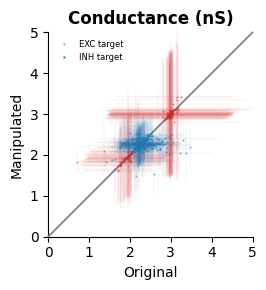

Mean decay_time data range: [4.808, 11.226]
Mean decay_time plot range: [4.000, 14.000]
144 data points
Mean decay_time data range: [6.214, 10.820]
Mean decay_time plot range: [4.000, 14.000]
336 data points


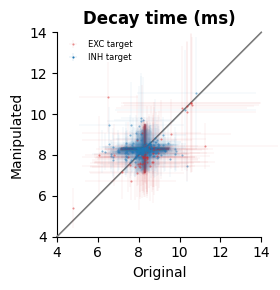

Mean delay data range: [0.918, 4.011]
Mean delay plot range: [0.000, 5.000]
144 data points
Mean delay data range: [0.718, 4.247]
Mean delay plot range: [0.000, 5.000]
336 data points


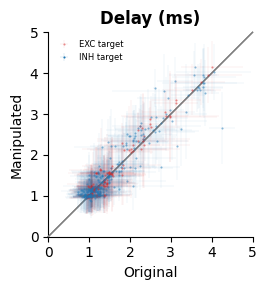

Mean depression_time data range: [52.844, 863.264]
Mean depression_time plot range: [0.000, 2500.000]
144 data points
Mean depression_time data range: [42.484, 2532.716]
Mean depression_time plot range: [0.000, 2500.000]
336 data points


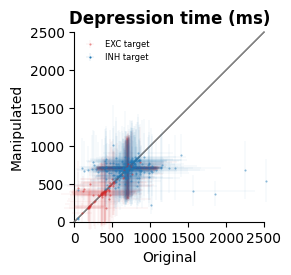

Mean facilitation_time data range: [18.994, 257.129]
Mean facilitation_time plot range: [0.000, 600.000]
144 data points
Mean facilitation_time data range: [5.875, 418.454]
Mean facilitation_time plot range: [0.000, 600.000]
336 data points


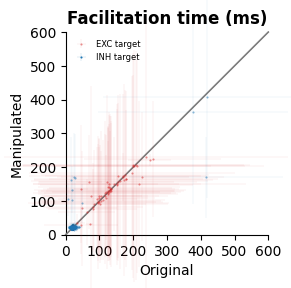

Mean n_rrp_vesicles data range: [1.000, 6.500]
Mean n_rrp_vesicles plot range: [0.000, 7.000]
144 data points
Mean n_rrp_vesicles data range: [1.000, 1.000]
Mean n_rrp_vesicles plot range: [0.000, 7.000]
336 data points


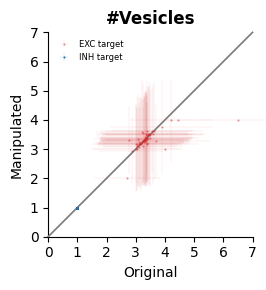

Mean u_syn data range: [0.155, 0.449]
Mean u_syn plot range: [0.000, 0.600]
144 data points
Mean u_syn data range: [0.137, 0.379]
Mean u_syn plot range: [0.000, 0.600]
336 data points


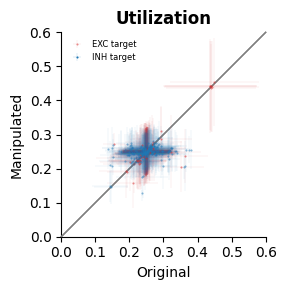

In [58]:
# Scatter plots
ax_limits = dict(conductance=[0, 5], decay_time=[4, 14], delay=[0, 5], depression_time=[0, 2500], facilitation_time=[0, 600], n_rrp_vesicles=[0, 7], u_syn=[0, 0.6])
for _pidx, _prop in enumerate(props_list):
    res_dicts_split = split_res_dicts(res_dicts, _prop, split_classes, exc_inh_mtypes)
    
    plt.figure(figsize=(3, 3))
    for rdicts, split_class, split_col in zip(res_dicts_split, split_classes, split_colors):
        plot_struct_res_scatter(rdicts[0], rdicts[1], _prop, props_name_mapping[_prop], ['Original', 'Manipulated'], 'm-type', err_sel=_prop + '_std', plot_range=ax_limits[_prop], plot_specs=dict(fmt='.', alpha=0.5, lw=0.1, ms=3, markeredgecolor='none'), colors=split_col, lgd_labels=[split_class + ' target'], lgd_specs=dict(frameon=False, loc='upper left', fontsize=6), new_fig=False)
    plt.gca().spines['left'].set_zorder(-1000)
    plt.gca().spines['bottom'].set_zorder(-1000)
    plt.tight_layout()
    plt.gca().set_xticks(plt.gca().get_yticks())
    if figs_path is not None:
        fn = f'struct_res_scatter__IntRew_{_prop}_by_m-type'
        plt.savefig(os.path.join(figs_path, f'{fn}.png'), dpi=600)
        plt.savefig(os.path.join(figs_path, f'{fn}.svg'), dpi=600)
    plt.show()

#### Overall numbers
- Conn prob and #syn/conn
- From all manipulated src types to EXC/INH

In [59]:
# Overall conn. prob. and #syn/conn from all manipulated src types to EXC/INH
orig_synaptome = syn_mats[0]
synaptome = syn_mats[1]
orig_adj = adj_mats[0]
adj = adj_mats[1]
tgt_class = nclass_all["synapse_class"].to_numpy()[sort_idx_all]

sel_post_e = tgt_class == "EXC"
sel_post_i = tgt_class == "INH"

n_e = orig_synaptome[:, sel_post_e].size
n_i = orig_synaptome[:, sel_post_i].size
nconn_all_orig = [n_e, n_i]
p_e = n_e / (orig_adj.shape[0] * np.sum(sel_post_e))
p_i = n_i / (orig_adj.shape[0] * np.sum(sel_post_i))
p_all_orig = np.array([p_e, p_i])

nsc_e = orig_synaptome[:, sel_post_e].data.mean()
nsc_i = orig_synaptome[:, sel_post_i].data.mean()
nsynconn_all_orig = [nsc_e, nsc_i]
s_e = orig_synaptome[:, sel_post_e].sum()
s_i = orig_synaptome[:, sel_post_i].sum()
nsyn_all_orig = [s_e, s_i]

n_e = synaptome[:, sel_post_e].size
n_i = synaptome[:, sel_post_i].size
nconn_all = [n_e, n_i]
p_e = n_e / (adj.shape[0] * np.sum(sel_post_e))
p_i = n_i / (adj.shape[0] * np.sum(sel_post_i))
p_all = np.array([p_e, p_i])

nsc_e = synaptome[:, sel_post_e].data.mean()
nsc_i = synaptome[:, sel_post_i].data.mean()
nsynconn_all = [nsc_e, nsc_i]
s_e = synaptome[:, sel_post_e].sum()
s_i = synaptome[:, sel_post_i].sum()
nsyn_all = [s_e, s_i]

print(f"#conn E/I: {nconn_all_orig} (orig), {nconn_all} (manip)")
print(f"#syn E/I: {nsyn_all_orig} (orig), {nsyn_all} (manip)")
print(f"conn prob E/I: {p_all_orig} (orig), {p_all} (manip)")
print(f"#syn/conn E/I: {nsynconn_all_orig} (orig), {nsynconn_all} (manip)")

#conn E/I: [83369, 6831] (orig), [446368, 287374] (manip)
#syn E/I: [1204043, 72643] (orig), [519620, 1073975] (manip)
conn prob E/I: [0.00587225 0.00378745] (orig), [0.03144077 0.15933444] (manip)
#syn/conn E/I: [14.442334680756636, 10.634314156053286] (orig), [1.1641067460032977, 3.7372030872660713] (manip)


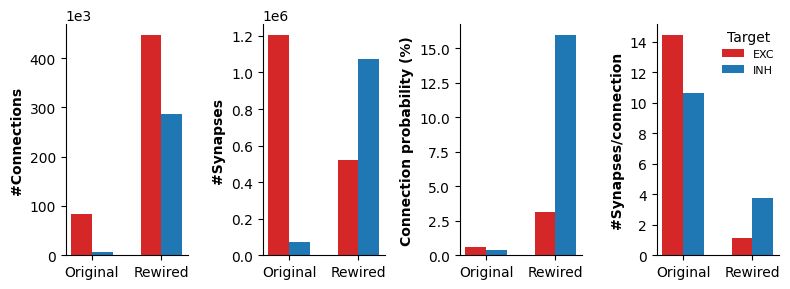

In [60]:
col_e = "tab:red"
col_i = "tab:blue"
x_lbl = ["Original", "Rewired"]
w = 0.3

plt.figure(figsize=(8, 3))
plt.subplot(1, 4, 1)
plt.bar(np.arange(len(x_lbl)) - w / 2, [nconn_all_orig[0], nconn_all[0]], width=w, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + w / 2, [nconn_all_orig[1], nconn_all[1]], width=w, color=col_i, label="INH")
plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("#Connections", fontweight="bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1, 4, 2)
plt.bar(np.arange(len(x_lbl)) - w / 2, [nsyn_all_orig[0], nsyn_all[0]], width=w, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + w / 2, [nsyn_all_orig[1], nsyn_all[1]], width=w, color=col_i, label="INH")
plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(6, 6))
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("#Synapses", fontweight="bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1, 4, 3)
plt.bar(np.arange(len(x_lbl)) - w / 2, [p_all_orig[0] * 100, p_all[0] * 100], width=w, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + w / 2, [p_all_orig[1] * 100, p_all[1] * 100], width=w, color=col_i, label="INH")
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("Connection probability (%)", fontweight="bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(1, 4, 4)
plt.bar(np.arange(len(x_lbl)) - w / 2, [nsynconn_all_orig[0], nsynconn_all[0]], width=w, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + w / 2, [nsynconn_all_orig[1], nsynconn_all[1]], width=w, color=col_i, label="INH")
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("#Synapses/connection", fontweight="bold")
plt.legend(title="Target", frameon=False, fontsize=8, loc="upper right", bbox_to_anchor=[1.05, 1.02])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'IntRew_overview__EXC_vs_INH.png'), dpi=600)
plt.savefig(os.path.join(figs_path, 'IntRew_overview__EXC_vs_INH.svg'), dpi=600)
plt.show()

### Visualize morphologies

- Example morphologies before and after rewiring
- Selection of a target neuron of each m-type which has highest indegree before (EXC) or after (INH) rewiring

ℹ️ Set results path below pointing to the location of the rewired circuit

In [61]:
res_circuit = Circuit('/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/circuits/SSCx-HexO1-Release__SSCX_hex0_inh_tc__hex0_rewired/circuit_config_tc.json')
res_edges = res_circuit.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']

In [63]:
# Load edges tables
def load_edges_tables(orig_edges, res_edges, src_tp_sel, tid):
    props_sel = ["@source_node", "@target_node", "afferent_center_x", "afferent_center_y", "afferent_center_z"]
    orig_edges_table = orig_edges.pathway_edges(source=src_tp_sel, target=tid, properties=props_sel)
    res_edges_table = res_edges.pathway_edges(source=src_tp_sel, target=tid, properties=props_sel)
#     print(f"Loaded synapses: ORIG {orig_edges_table.shape[0]} synapses, MANIP {res_edges_table.shape[0]} synapses")
    return orig_edges_table, res_edges_table

# Access target (dendritic) morphology
def load_morphology(nodes, tid):
    get_tgt_morph = lambda node_id: nodes.morph.get(node_id, transform=True, extension='asc') # Access function (incl. transformation!), using ASCII format

    nrn_morph = get_tgt_morph(tid)  # Target morphology
    dd_types = list(filter(lambda tp: "dendrite" in tp.name, nm.NEURITE_TYPES))  # Select dendrite types
    dd_sel = np.isin(nrn_morph.section_types, dd_types)
    dd_points = [_sec.points for _sel, _sec in zip(dd_sel, nrn_morph.sections) if _sel]  # Dendrite points
    soma_pos = nrn_morph.soma.center

    return soma_pos, dd_points

CLASS_COLORS = {"EXC": "tab:red", "INH": "tab:blue"}
TYPE_COLORS = {_tp: plt.cm.Dark2(np.linspace(0, 1, 8))[_idx] for _idx, _tp in enumerate(src_types)}
SYN_SPEC = {"marker": ".", "ms": 3}

def plot_syn_on_morph(nodes, soma_pos, dd_points, src_tp_sel, tid, orig_edges_table, res_edges_table, save_path=None, fn_prefix=""):

    tgt_class = nodes.get(tid, properties="synapse_class")
    tgt_type = nodes.get(tid, properties='mtype')

    plt.figure(figsize=(5, 2))

    # ORIG
    plt.subplot(1, 2, 1, projection="3d")

    ## Plot target morphology
    plt.plot(*soma_pos, "o", color=CLASS_COLORS[tgt_class], alpha=1.0, markeredgecolor="none")
    for _i, _p in enumerate(dd_points):
        plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], "-", color=CLASS_COLORS[tgt_class], lw=0.5, alpha=1.0)

    ## Plot synapses
    lbl_list = {}
    for _sidx, _src in enumerate(src_tp_sel):
        _s_tp = nodes.get(_src, properties='mtype')
        if _src in orig_edges_table["@source_node"].to_numpy():
            h = plt.plot(
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_x"],
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_y"],
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_z"],
                linestyle="", color=TYPE_COLORS[_s_tp], **SYN_SPEC,
            )
            lbl_list[_s_tp] = h[0]

    ## Plot labels
    tab_sel = np.isin(orig_edges_table["@source_node"], src_tp_sel)
    nsyn = np.sum(tab_sel)
    nconn = len(np.unique(orig_edges_table["@source_node"][tab_sel]))
    nsyn_tp = {}
    nconn_tp = {}
    s_tps = np.array([nodes.get(_id, properties='mtype') for _id in orig_edges_table[tab_sel]["@source_node"]])
    for _tp in TYPE_COLORS.keys():
        _sel = s_tps == _tp
        nsyn_tp[_tp] = np.sum(_sel)
        if nsyn_tp[_tp] == 0:
            nconn_tp[_tp] = 0
        else:
            nconn_tp[_tp] = len(np.unique(orig_edges_table[tab_sel][_sel]["@source_node"]))
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"Original\n", fontweight="bold", ha="center", va="bottom")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"\n({nsyn} syn, {nconn} conn)", ha="center", va="bottom")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"Target ID {tid}\n({tgt_type}, {tgt_class})", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    if len(lbl_list) > 0:
        lgd_handles = [lbl_list[_tp] for _tp in sorted(lbl_list.keys())]
        lgd_labels = [f"{_tp} ({nsyn_tp[_tp]}/{nconn_tp[_tp]})" for _tp in sorted(lbl_list.keys())]
        plt.legend(handles=lgd_handles, labels=lgd_labels, frameon=False, fontsize=5, title_fontsize=6, title="Sources (syn/conn)", loc="lower right", bbox_to_anchor=[1.4, 0.0])

    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")
    plt.gca().set_zlabel("z")

    plt.gca().view_init(0, -90)
    plt.axis("image")
    plt.axis("off")

    # MANIP
    plt.subplot(1, 2, 2, projection="3d")

    ## Plot target morphology
    plt.plot(*soma_pos, "o", color=CLASS_COLORS[tgt_class], alpha=1.0, markeredgecolor="none")
    for _i, _p in enumerate(dd_points):
        plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], "-", color=CLASS_COLORS[tgt_class], lw=0.5, alpha=1.0)

    ## Plot synapses
    lbl_list = {}
    for _sidx, _src in enumerate(src_tp_sel):
        _s_tp = nodes.get(_src, properties='mtype')
        if _src in res_edges_table["@source_node"].to_numpy():
            h = plt.plot(
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_x"],
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_y"],
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_z"],
                linestyle="", color=TYPE_COLORS[_s_tp], **SYN_SPEC,
            )
            lbl_list[_s_tp] = h[0]

    ## Plot labels
    tab_sel = np.isin(res_edges_table["@source_node"], src_tp_sel)
    nsyn = np.sum(tab_sel)
    nconn = len(np.unique(res_edges_table["@source_node"][tab_sel]))
    nsyn_tp = {}
    nconn_tp = {}
    s_tps = np.array([nodes.get(_id, properties='mtype') for _id in res_edges_table[tab_sel]["@source_node"]])
    for _tp in TYPE_COLORS.keys():
        _sel = s_tps == _tp
        nsyn_tp[_tp] = np.sum(_sel)
        if nsyn_tp[_tp] == 0:
            nconn_tp[_tp] = 0
        else:
            nconn_tp[_tp] = len(np.unique(res_edges_table[tab_sel][_sel]["@source_node"]))
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"Rewired\n", fontweight="bold", ha="center", va="bottom")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"\n({nsyn} syn, {nconn} conn)", ha="center", va="bottom")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"Target ID {tid}\n({tgt_type}, {tgt_class})", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    if len(lbl_list) > 0:
        lgd_handles = [lbl_list[_tp] for _tp in sorted(lbl_list.keys())]
        lgd_labels = [f"{_tp} ({nsyn_tp[_tp]}/{nconn_tp[_tp]})" for _tp in sorted(lbl_list.keys())]
        plt.legend(handles=lgd_handles, labels=lgd_labels, frameon=False, fontsize=5, title_fontsize=6, title="Sources (syn/conn)", loc="lower right", bbox_to_anchor=[1.4, 0.0])

    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")
    plt.gca().set_zlabel("z")

    plt.gca().view_init(0, -90)
    plt.axis("image")
    plt.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f"{fn_prefix}morphology_{tgt_class}_{tgt_type.replace(':', '-')}_ID{tid}.png"), dpi=600, bbox_inches="tight", pad_inches=0.2)
        plt.savefig(os.path.join(save_path, f"{fn_prefix}morphology_{tgt_class}_{tgt_type.replace(':', '-')}_ID{tid}.svg"), dpi=600, bbox_inches="tight", pad_inches=0.2)
    plt.show()

In [64]:
# Select target neurons with highest indegree (before (EXC) or after (INH) rewiring)
nclass_all_sort = nclass_all.iloc[sort_idx_all]
tid_list = []
tgt_types = list(np.unique(nclass_all_sort['mtype']))
for tgt_type in tgt_types:
    tgt_tp_sel = nclass_all_sort['mtype'] == tgt_type
    if nclass_all_sort[tgt_tp_sel]['synapse_class'].iloc[0] == 'EXC':
        tgt_indeg = orig_adj[:, tgt_tp_sel].sum(0)
    else:
        tgt_indeg = adj[:, tgt_tp_sel].sum(0)
    tid = nclass_all_sort[tgt_tp_sel].index[np.argmax(tgt_indeg)]
    tid_list.append(tid)

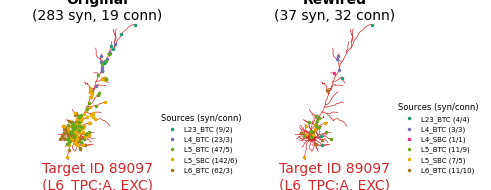

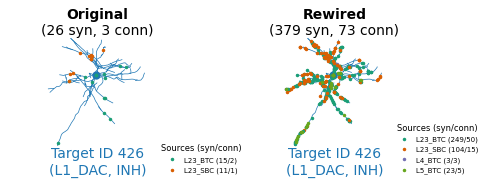

In [65]:
# Plot morphology & synapses (before and after rewiring)
for tid in [89097, 426]:  # Selected node IDs for main figure
    orig_edges_table, res_edges_table = load_edges_tables(edges, res_edges, nids_src, tid)
    soma_pos, dd_points = load_morphology(nodes, tid)
    plot_syn_on_morph(nodes, soma_pos, dd_points, nids_src, tid, orig_edges_table, res_edges_table, figs_path)

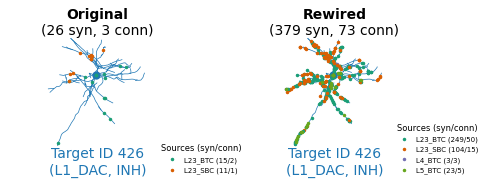

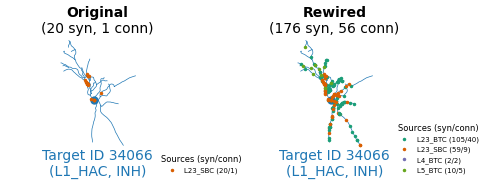

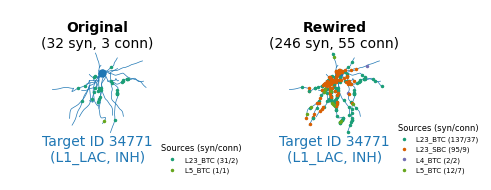

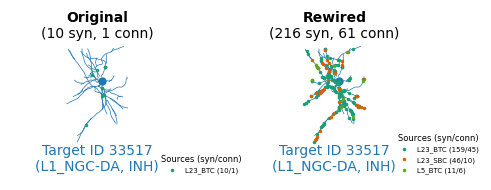

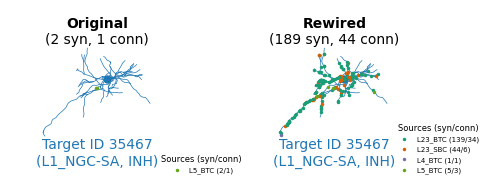

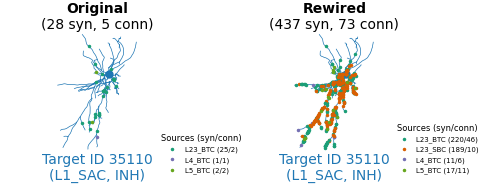

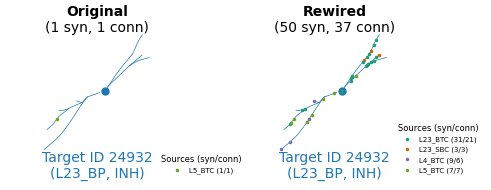

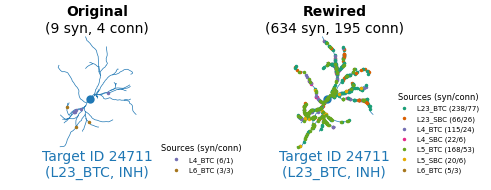

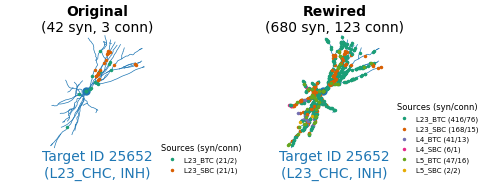

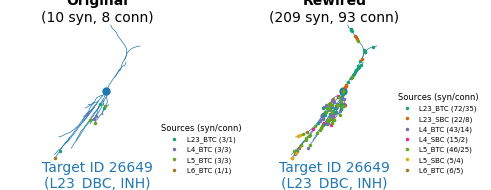

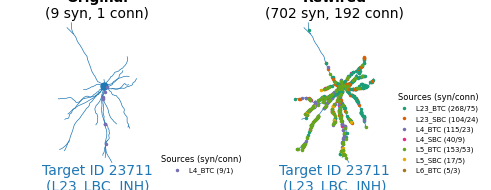

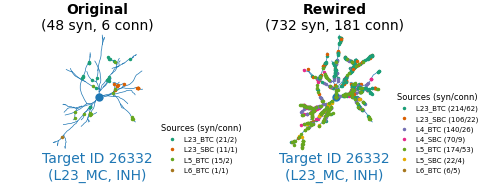

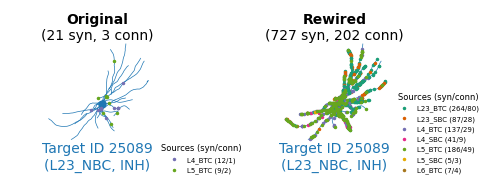

/nvme/pokorny/2244204/ipykernel_12882/1609834756.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  _sel = s_tps == _tp


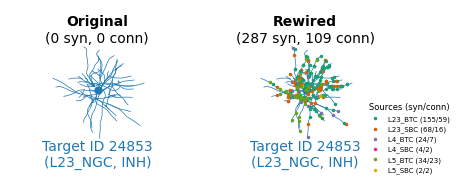

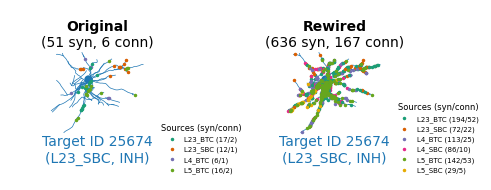

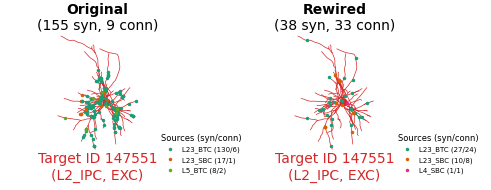

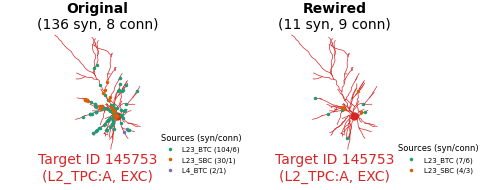

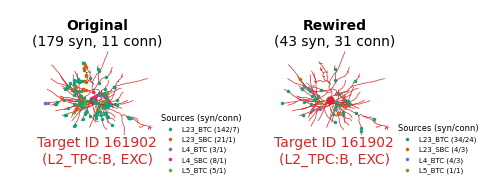

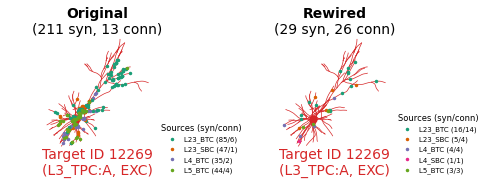

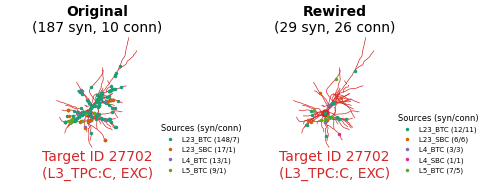

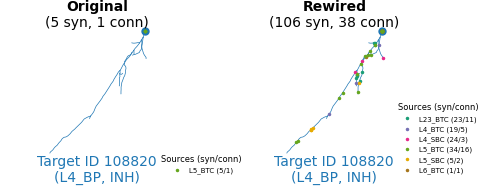

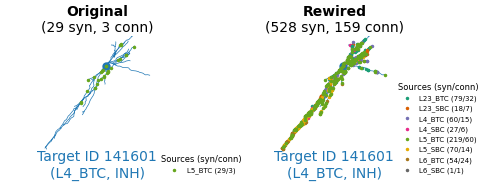

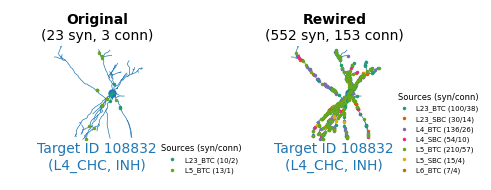

/nvme/pokorny/2244204/ipykernel_12882/1609834756.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  _sel = s_tps == _tp


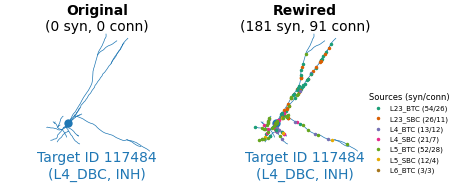

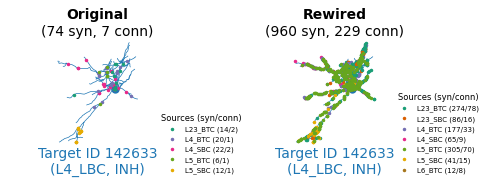

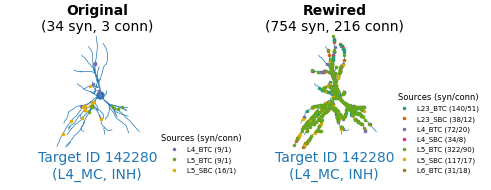

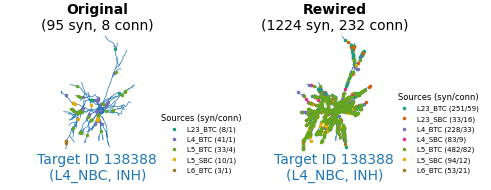

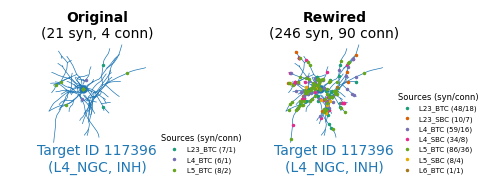

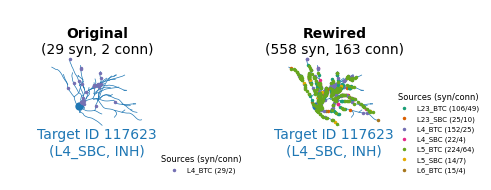

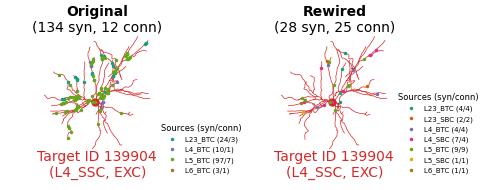

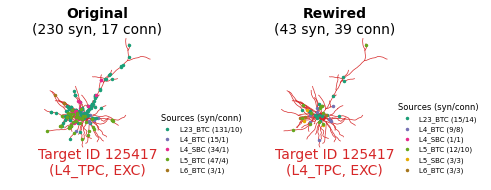

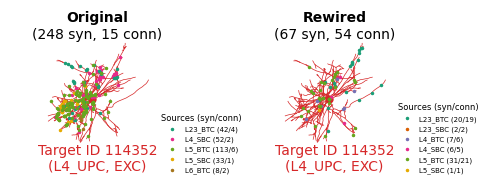

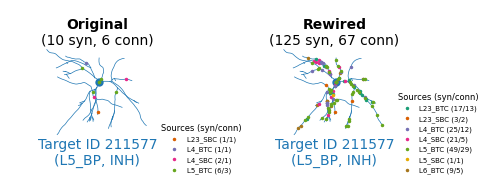

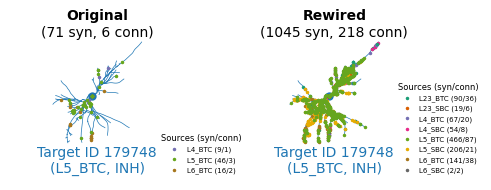

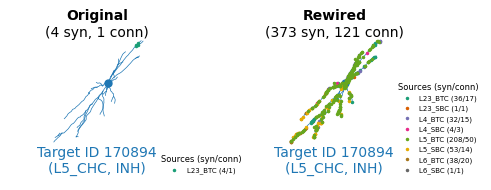

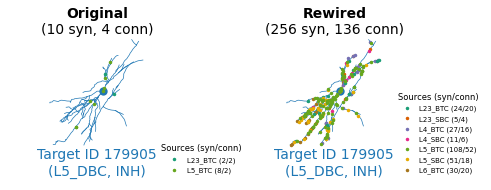

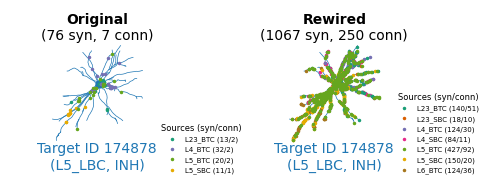

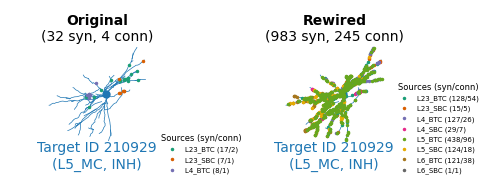

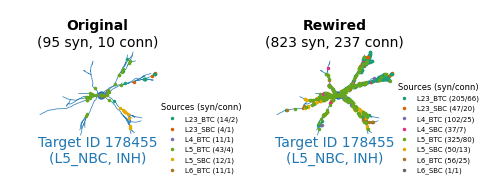

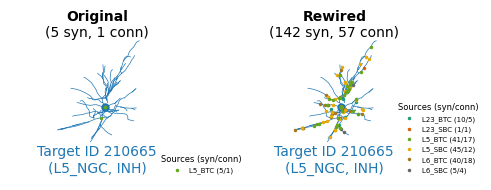

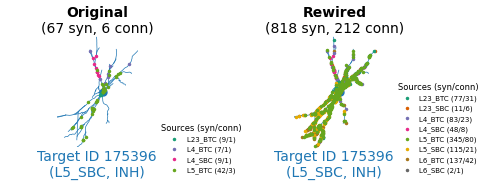

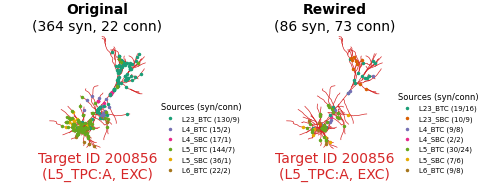

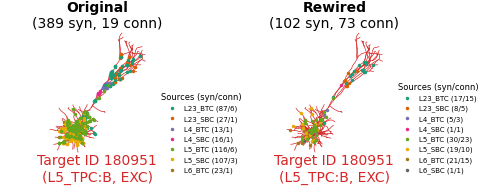

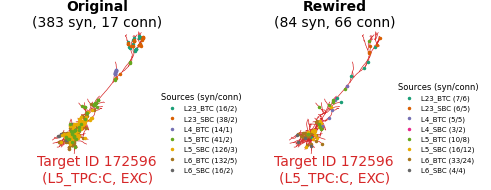

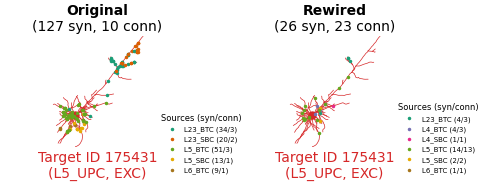

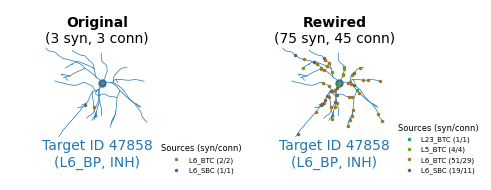

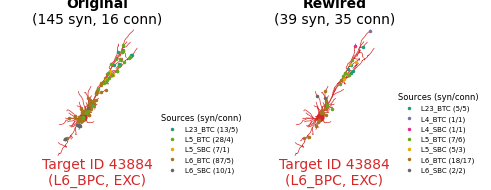

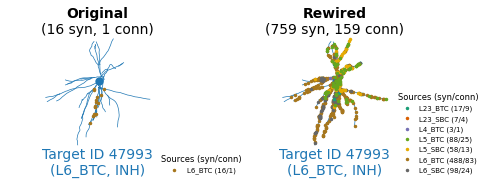

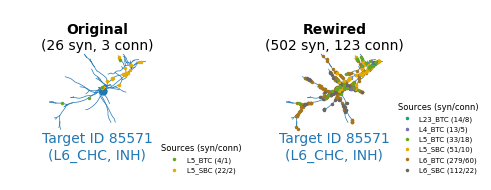

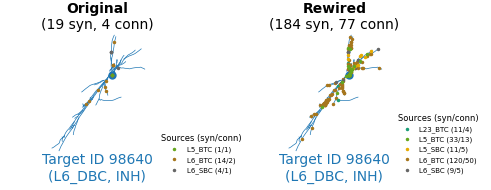

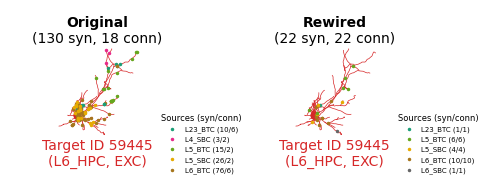

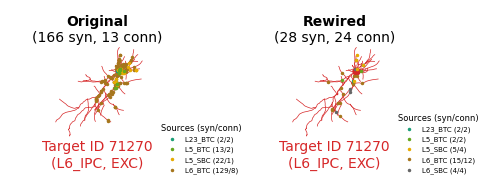

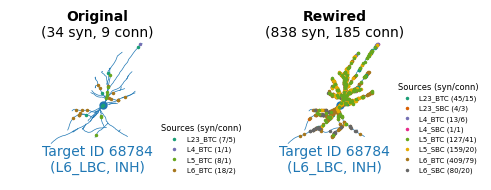

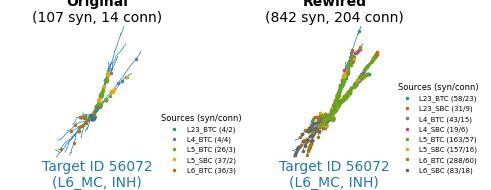

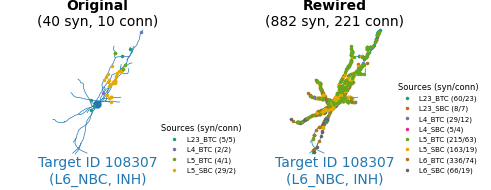

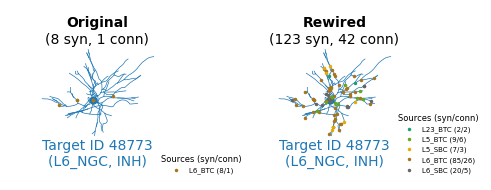

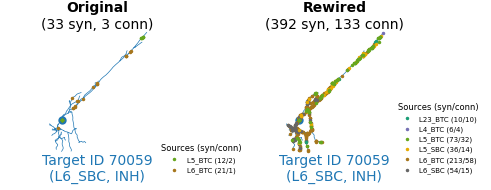

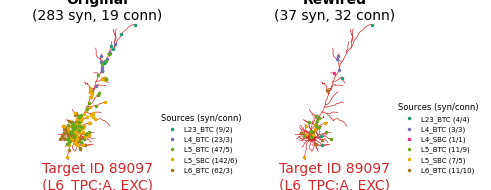

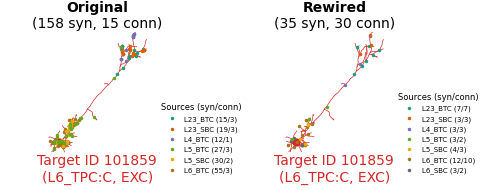

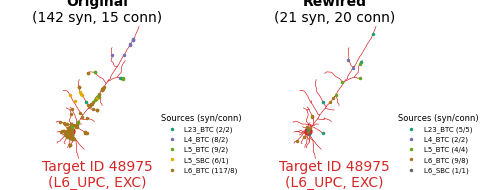

In [66]:
morph_path = os.path.join(figs_path, 'morphs_all')
if not os.path.exists(morph_path):
    os.makedirs(morph_path)
for _idx, tid in enumerate(tid_list):  # One selected node ID for all m-types
    orig_edges_table, res_edges_table = load_edges_tables(edges, res_edges, nids_src, tid)
    soma_pos, dd_points = load_morphology(nodes, tid)
    plot_syn_on_morph(nodes, soma_pos, dd_points, nids_src, tid, orig_edges_table, res_edges_table, morph_path, fn_prefix=f'{_idx + 1:02d}_')

---
## Simplified connectomes

Results figures related to SSCx rewiring based on five simplified models of connectivity.

### Results from model fitting

ℹ️ Set results path below pointing to the location of the fitted order 1-5 models

In [67]:
model_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_building/SSCx-HexO1-Release/model'

In [68]:
model_files = [os.path.join(model_path, 'ConnProb1stOrder-SSCxO1-Hex0EE.json'),
               os.path.join(model_path, 'ConnProb2ndOrderComplex-SSCxO1-Hex0EE.json'),
               os.path.join(model_path, 'ConnProb3rdOrderComplex-SSCxO1-Hex0EE.json'),
               os.path.join(model_path, 'ConnProb4thOrder-SSCxO1-Hex0EE.json'),
               os.path.join(model_path, 'ConnProb5thOrder-SSCxO1-Hex0EE.json')]

# Plot ranges
p_range = [0.0, 0.1]  # Probability range for plotting
p_ticks = 6
cmap = plt.cm.hot

# Font sizes
tit_fs = 24
lbl_fs = 20
txt_fs = 15
tick_fs = 14

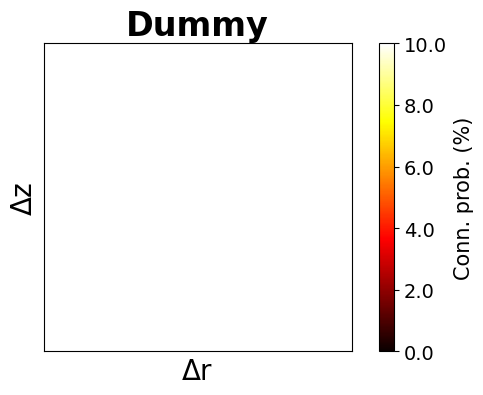

In [69]:
# Plot colorbar
plt.figure(figsize=(7, 4))
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(plot_range, -plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = np.full_like(vdist, np.nan)
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, -plot_range, plot_range), cmap=cmap, vmin=100 * p_range[0], vmax=100 * p_range[1])
plt.xticks([])
plt.yticks([])
plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
plt.ylabel('$\\Delta$z', fontsize=lbl_fs)
plt.title('Dummy', fontweight='bold', fontsize=tit_fs)
h_cb = plt.colorbar(aspect=20.0)
h_cb.set_label("Conn. prob. (%)", fontsize=15, labelpad=5)
tick_vals = np.linspace(100 * p_range[0], 100 * p_range[1], p_ticks)
h_cb.set_ticks(tick_vals, labels=[f"{_v:.1f}" for _v in tick_vals], fontsize=tick_fs)
        
# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_colorbar.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_colorbar.svg'), dpi=600)
plt.show()

ConnProb1stOrderModel
  p_conn() = 0.010 (constant)


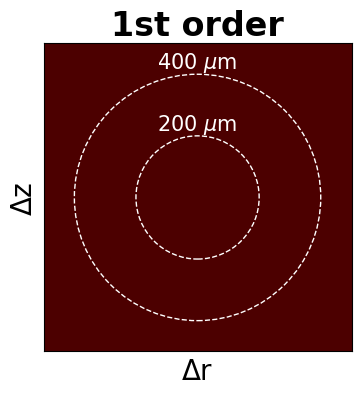

In [70]:
# 1st-order model
model = model_types.AbstractModel.model_from_file(model_files[0])

model_params = model.get_param_dict()
print(model)

plt.figure(figsize=(4, 4))
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(plot_range, -plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = np.full_like(vdist, model.get_conn_prob())
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, -plot_range, plot_range), cmap=cmap, vmin=p_range[0], vmax=p_range[1])
for r in r_markers:
    plt.gca().add_patch(plt.Circle((0, 0), r, edgecolor='w', linestyle='--', fill=False))
    plt.text(0, r, f'{r} $\\mu$m', color='w', ha='center', va='bottom', fontsize=txt_fs)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
plt.ylabel('$\\Delta$z', fontsize=lbl_fs)
plt.title('1st order', fontweight='bold', fontsize=tit_fs)

# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_1.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_1.svg'), dpi=600)
plt.show()

ConnProb2ndOrderComplexExpModel
  p_conn(d) = 0.084 * exp(-0.000186 * d^1.735) + 0.017 * exp(-0.002 * d)
  d...distance


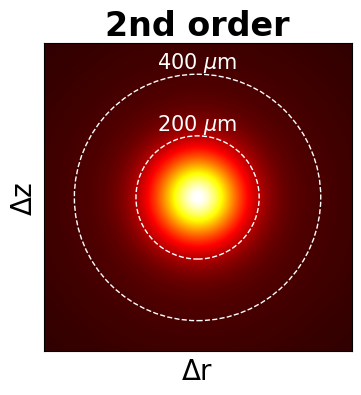

In [71]:
# 2nd-order model
model = model_types.AbstractModel.model_from_file(model_files[1])

model_params = model.get_param_dict()
print(model)

plt.figure(figsize=(4, 4))
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(plot_range, -plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = model.get_conn_prob(vdist)
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, -plot_range, plot_range), cmap=cmap, vmin=p_range[0], vmax=p_range[1])
for r in r_markers:
    plt.gca().add_patch(plt.Circle((0, 0), r, edgecolor='w', linestyle='--', fill=False))
    plt.text(0, r, f'{r} $\\mu$m', color='w', ha='center', va='bottom', fontsize=txt_fs)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
plt.ylabel('$\\Delta$z', fontsize=lbl_fs)
plt.title('2nd order', fontweight='bold', fontsize=tit_fs)

# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_2.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_2.svg'), dpi=600)
plt.show()

ConnProb3rdOrderComplexExpModel
  p_conn(d, delta) = 0.087 * exp(-0.000042 * d^2.000) + 0.024 * exp(-0.001 * d) if delta < 0
                     0.081 * exp(-0.001004 * d^1.444) + 0.013 * exp(-0.003 * d) if delta > 0
                     AVERAGE OF BOTH MODELS  if delta == 0
  d...distance, delta...difference (tgt minus src) in coordinate 2


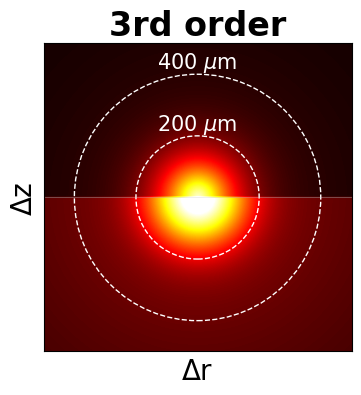

In [72]:
# 3rd-order model
model = model_types.AbstractModel.model_from_file(model_files[2])

model_params = model.get_param_dict()
print(model)

plt.figure(figsize=(4, 4))
plot_range = 500 # (um)
r_markers = [200, 400] # (um)
dx = np.linspace(-plot_range, plot_range, 201)
dz = np.linspace(plot_range, -plot_range, 201)
xv, zv = np.meshgrid(dx, dz)
vdist = np.sqrt(xv**2 + zv**2)
pdist = model.get_conn_prob(vdist, np.sign(zv))
plt.imshow(pdist, interpolation='bilinear', extent=(-plot_range, plot_range, -plot_range, plot_range), cmap=cmap, vmin=p_range[0], vmax=p_range[1])
plt.plot(plt.xlim(), np.zeros(2), 'lightgrey', linewidth=0.5, alpha=0.5)
for r in r_markers:
    plt.gca().add_patch(plt.Circle((0, 0), r, edgecolor='w', linestyle='--', fill=False))
    plt.text(0, r, f'{r} $\\mu$m', color='w', ha='center', va='bottom', fontsize=txt_fs)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
plt.ylabel('$\\Delta$z', fontsize=lbl_fs)
plt.title('3rd order', fontweight='bold', fontsize=tit_fs)

# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_3.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_3.svg'), dpi=600)
plt.show()

ConnProb4thOrderLinInterpnReducedModel
  p_conn(dr, dz) = LINEAR INTERPOLATION FROM DATA TABLE (396 entries; dr(9): 25.00..425.00, dz(44): -1525.00..625.00)
  dr/dz...radial/axial position offset (tgt minus src), with axial coordinate 2


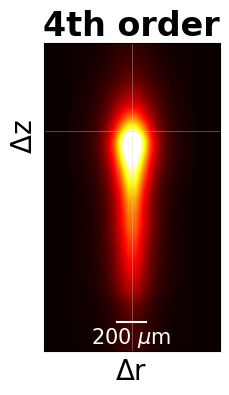

In [73]:
# 4th-order model
model = model_types.AbstractModel.model_from_file(model_files[3])

model_params = model.get_param_dict()
print(model)

dr_bin_size = dz_bin_size = 1
dr_bins = np.arange(0, 601, dr_bin_size)
dz_bins = np.arange(-1500, 601, dz_bin_size)

# Sample positions (at bin centers)
dr_pos = dr_bins[:-1] + 0.5 * dr_bin_size
dz_pos = dz_bins[:-1] + 0.5 * dz_bin_size

# Model probability at sample positions
drv, dzv = np.meshgrid(dr_pos, dz_pos, indexing='ij')
model_pos = np.array([drv.flatten(), dzv.flatten()]).T # Regular grid
model_val = model.get_conn_prob(model_pos[:, 0], model_pos[:, 1])
model_val = model_val.reshape([len(dr_pos), len(dz_pos)])

plt.figure(figsize=(4, 4))
plt.imshow(np.hstack([model_val.T[:, ::-1], model_val.T]), interpolation='nearest', extent=(-dr_bins[-1], dr_bins[-1], dz_bins[-1], dz_bins[0]), cmap=cmap, vmin=p_range[0], vmax=p_range[1])
plt.plot(np.zeros(2), plt.ylim(), color='lightgrey', linewidth=0.5, alpha=0.5)
plt.plot(plt.xlim(), np.zeros(2), 'lightgrey', linewidth=0.5, alpha=0.5)
bar_x = [-100, 100]
bar_y = -1300
plt.plot(bar_x, [bar_y] * 2, 'w-')
plt.text(np.mean(bar_x), bar_y - 20, f'{np.diff(bar_x)[0]} $\\mu$m', color='w', ha='center', va='top', fontsize=txt_fs)
plt.plot()
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
plt.ylabel(' ' * 14 + '$\\Delta$z', fontsize=lbl_fs)
plt.title('4th order', fontweight='bold', fontsize=tit_fs)

# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_4.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_4.svg'), dpi=600)
plt.show()

ConnProb5thOrderLinInterpnReducedModel
  p_conn(z, dr, dz) = LINEAR INTERPOLATION FROM DATA TABLE (5148 entries; z(13): -2300.00..100.00, dr(9): 25.00..425.00, dz(44): -1525.00..625.00)
  z...axial src position, dr/dz...radial/axial position offset (tgt minus src), with axial coordinate 2


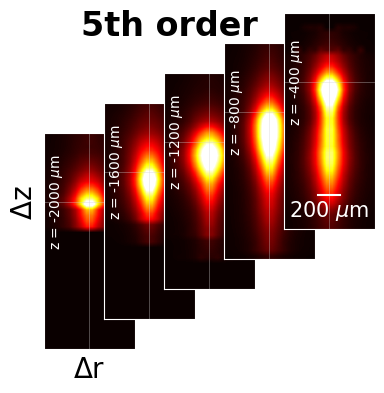

In [74]:
# 5th-order model
model = model_types.AbstractModel.model_from_file(model_files[4])

model_params = model.get_param_dict()
print(model)

z_pos_list = np.arange(-2000, 0, 400)

x_step = 0.15
y_step = 0.075
p_max = np.round(np.max(model.p_conn_table.to_numpy()), decimals=1)
ax_list = []

plt.figure(figsize=(4, 4))
for zi in range(len(z_pos_list)):
    ax_list.append(plt.axes([0.05 + zi * x_step, 0.1 + zi * y_step, 0.4, 0.54]))
    z_pos = [z_pos_list[zi]]

    dr_bin_size = dz_bin_size = 1
    dr_bins = np.arange(0, 401, dr_bin_size)
    dz_bins = np.arange(-1300, 601, dz_bin_size)

    # Sample positions (at bin centers)
    dr_pos = dr_bins[:-1] + 0.5 * dr_bin_size
    dz_pos = dz_bins[:-1] + 0.5 * dz_bin_size

    # Model probability at sample positions
    zv, drv, dzv = np.meshgrid(z_pos, dr_pos, dz_pos, indexing='ij')
    model_pos = np.array([zv.flatten(), drv.flatten(), dzv.flatten()]).T # Regular grid
    model_val = model.get_conn_prob(model_pos[:, 0], model_pos[:, 1], model_pos[:, 2])
    model_val = model_val.reshape([len(z_pos), len(dr_pos), len(dz_pos)])

    plt.imshow(np.hstack([model_val.T[:, ::-1], model_val.T]), interpolation='nearest', extent=(-dr_bins[-1], dr_bins[-1], dz_bins[-1], dz_bins[0]), cmap=cmap, vmin=p_range[0], vmax=p_range[1])
    plt.plot(np.zeros(2), plt.ylim(), color='lightgrey', linewidth=0.5, alpha=0.5)
    plt.plot(plt.xlim(), np.zeros(2), 'lightgrey', linewidth=0.5, alpha=0.5)
    if zi == 0:
        plt.xlabel('$\\Delta$r', fontsize=lbl_fs)
        plt.ylabel(' ' * 9 + '$\\Delta$z', fontsize=lbl_fs)
    if zi == len(z_pos_list) - 2:
        plt.title('5th order' + ' ' * 1, ha='right', fontweight='bold', fontsize=tit_fs)
    if zi == len(z_pos_list) - 1:
        bar_x = [-100, 100]
        bar_y = -1000
        plt.plot(bar_x, [bar_y] * 2, 'w-')
        plt.text(np.mean(bar_x), bar_y - 20, f'{np.diff(bar_x)[0]} $\\mu$m', color='w', ha='center', va='top', fontsize=txt_fs)
    plt.gca().invert_yaxis()
    plt.text(np.min(plt.xlim()) + 40, 0, f'z = {z_pos_list[zi]} $\\mu$m', color='w', fontsize=10, ha='left', va='center', rotation=90)
    plt.xticks([])
    plt.yticks([])

    plt.gca().spines['bottom'].set_color('w')
    plt.gca().spines['top'].set_color('w') 
    plt.gca().spines['right'].set_color('w')
    plt.gca().spines['left'].set_color('w')

# plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'model_order_5.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'model_order_5.svg'), dpi=600)
plt.show()

### Number of connections & synapses in rewired connectomes

- Numbers collected from rewiring log files, see `SSCx_rewiring.ipynb`

In [75]:
n_ord = [1, 2, 3, 4, 5]

# Connection counts in Hex0EE column
N_conn = np.array([7203362, 7205703, 7203361, 7203364, 7203362, 7203362])
N_conn_diff = N_conn[1:] - N_conn[0]
N_conn_diff_pct = 100.0 * N_conn_diff / N_conn[0]

# Synapse counts in Hex0EE column
N_syn = np.array([31212240, 26603307, 29272858, 30173482, 30332403, 31153461])
N_syn_diff = N_syn[1:] - N_syn[0]
N_syn_diff_pct = 100.0 * N_syn_diff / N_syn[0]

In [76]:
print("<CONNECTIONS>")
for _ord, _n, _diff, _pct in zip([None] + n_ord, N_conn.tolist(), [np.nan] + N_conn_diff.tolist(), [np.nan] + N_conn_diff_pct.tolist()):
    _nm = f" Order {_ord}" if _ord else "Original"
    print(f"{_nm}: {_n}, DIFF: {_diff}, {_pct:.3f}%")

print()
print("<SYNAPSES>")
for _ord, _n, _diff, _pct in zip([None] + n_ord, N_syn.tolist(), [np.nan] + N_syn_diff.tolist(), [np.nan] + N_syn_diff_pct.tolist()):
    _nm = f" Order {_ord}" if _ord else "Original"
    print(f"{_nm}: {_n}, DIFF: {_diff}, {_pct:.3f}%")


<CONNECTIONS>
Original: 7203362, DIFF: nan, nan%
 Order 1: 7205703, DIFF: 2341, 0.032%
 Order 2: 7203361, DIFF: -1, -0.000%
 Order 3: 7203364, DIFF: 2, 0.000%
 Order 4: 7203362, DIFF: 0, 0.000%
 Order 5: 7203362, DIFF: 0, 0.000%

<SYNAPSES>
Original: 31212240, DIFF: nan, nan%
 Order 1: 26603307, DIFF: -4608933, -14.766%
 Order 2: 29272858, DIFF: -1939382, -6.214%
 Order 3: 30173482, DIFF: -1038758, -3.328%
 Order 4: 30332403, DIFF: -879837, -2.819%
 Order 5: 31153461, DIFF: -58779, -0.188%


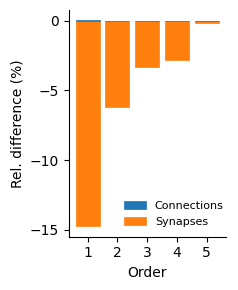

In [77]:
plot_specs = [{"color": "tab:blue", "edgecolor": "tab:blue", "lw": 0.5, "label": "Connections"},
              {"color": "tab:orange", "edgecolor": "tab:orange", "lw": 0.5, "label": "Synapses"}]

plt.figure(figsize=(2.5, 3))
plt.bar(n_ord, N_conn_diff_pct, **plot_specs[0])
plt.bar(n_ord, N_syn_diff_pct, **plot_specs[1], zorder=0)
# plt.plot([np.min(n_ord) - 0.5, np.max(n_ord) + 0.5], [0, 0], color="grey", lw=0.5, zorder=-100)
# plt.xlim(plt.xlim())
# plt.plot(plt.xlim(), [0, 0], color="grey", lw=0.5, zorder=-100)
plt.xticks(n_ord)
plt.yticks(np.linspace(-15, 0, 4))
plt.xlabel("Order")
plt.ylabel("Rel. difference (%)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, loc="lower right", bbox_to_anchor=[1.05, 0.0], fontsize=8)
plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'count_diffs.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'count_diffs.svg'), dpi=600)
plt.show()

### Model order validation

Mean-squared error (MSE) between connection probabilities obtained from five probability models re-extracted from each of the five simplified connectomes. Pre-computed in `SSCx_model_order_validation.ipynb`.

ℹ️ Set results path below pointing to the location of the model order validation results

In [103]:
# Load validation results
res_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_validation/prob_model_errors.pickle'

with open(res_file, 'rb') as f:
    res_dict = pickle.load(f)
model_errors_mse = res_dict['model_errors_mse']
order_list = res_dict['order_list']
prob_model_names = res_dict['prob_model_names']
circuit_names_manip = res_dict['circuit_names_manip']
p_kwargs = res_dict['p_kwargs']

print(f'Loaded prob. model. validation results for...')
print(f'  Conn. prob. models:\n{prob_model_names}')
print(f'  Manipulated circuits:\n{circuit_names_manip}')
print('  Probabilities probed at...', flush=True)
for _k, _v in p_kwargs.items():
    print(f'  {_k}: {np.min(_v)}..{np.max(_v)} ({len(_v)})', flush=True)


Loaded prob. model. validation results for...
  Conn. prob. models:
['ConnProb1stOrder-SSCxO1-Hex0EE', 'ConnProb2ndOrderComplex-SSCxO1-Hex0EE', 'ConnProb3rdOrderComplex-SSCxO1-Hex0EE', 'ConnProb4thOrder-SSCxO1-Hex0EE', 'ConnProb5thOrder-SSCxO1-Hex0EE']
  Manipulated circuits:
['SSCx-HexO1-Release__ConnRewireOrder1Hex0EE', 'SSCx-HexO1-Release__ConnRewireOrder2Hex0EE', 'SSCx-HexO1-Release__ConnRewireOrder3Hex0EE', 'SSCx-HexO1-Release__ConnRewireOrder4Hex0EE', 'SSCx-HexO1-Release__ConnRewireOrder5Hex0EE']
  Probabilities probed at...
  dist: 0..2500 (251)
  dr: 0..500 (51)
  dz: -1600..600 (221)
  z: -2000..0 (201)


In [104]:
# Define line colors for original and order 1-5 models
ORDER_COLORS = ['black', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']

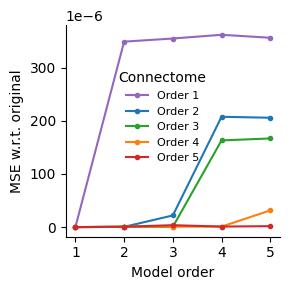

In [111]:
# Plot order validation results
plt.figure(figsize=(3, 3))
for _ord in range(model_errors_mse.shape[1]):
    plt.plot(order_list, model_errors_mse[:, _ord], '.-', color=ORDER_COLORS[1 + _ord])
plt.xticks(order_list)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-6, -6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Model order')
plt.ylabel('MSE w.r.t. original')
plt.legend([f'Order {_ord}' for _ord in order_list], title='Connectome', frameon=False, loc="lower left", bbox_to_anchor=[0.2, 0.3], fontsize=8)
plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'conn_order_validation.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'conn_order_validation.svg'), dpi=600)
plt.show()

<u>Caption</u>: Mean squared error of the connection probabilities obtained from the given models (x axis) extracted from simplified connectomes (as indicated by the legend) vs. extracted from the original connectome.

### Structural comparison

ℹ️ Set results path below pointing to location of structural comparison results

In [112]:
# Path to structural comparison results
struct_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/structural_comparator/SSCx-HexO1-Release/data'

_SSCx network model:_ Download and extract `O1_data_physiology_withfix.xz` and set path accordingly:

In [113]:
# Path to SSCx network model
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json'  # Released 210K nbS1 (SSCx HexO1) physiology circuit from [Isbister et al. 2023]

#### Adjacency validation

- Full hex0 adjacency matrix, grouped by E/I pathways
- Showing that IE/EI/II pathways are unchanged
- Optional: Subsampling of neurons for better visualization

In [114]:
# Paths to structural comparison results (first file = original)
order_list = [1, 2, 3, 4, 5]
struct_files = [os.path.join(struct_path, 'Orig_Adjacency_Hex0.pickle')] + \
               [os.path.join(struct_path, f'Order-{_ord}_Adjacency_Hex0.pickle') for _ord in order_list]

In [115]:
c = Circuit(circuit_config)
nodes = c.nodes['S1nonbarrel_neurons']
node_set = 'hex0'
nclass_all = nodes.get(node_set, ['synapse_class', 'layer'])
nids_all = nclass_all.index.values
nids_exc = nclass_all[nclass_all['synapse_class'] == 'EXC'].index.values
nids_inh = nclass_all[nclass_all['synapse_class'] == 'INH'].index.values
nclass_all['sort_idx'] = range(nclass_all.shape[0])
sort_idx = nclass_all.sort_values(by=['synapse_class', 'layer'])['sort_idx'].values  # Sort by synapse class & layer
print(f'INFO: {len(nids_all)} "{node_set}" cells, {len(nids_exc)} EXC, {len(nids_inh)} INH')

# Check EXC/INH separation
assert np.all(np.isin(nids_all[sort_idx][:len(nids_exc)], nids_exc)), 'ERROR: EXC sort error!'
assert np.all(np.isin(nids_all[sort_idx][len(nids_exc):], nids_inh)), 'ERROR: INH sort error!'

INFO: 30190 "hex0" cells, 26787 EXC, 3403 INH


In [86]:
# Load adj. matrices and compute difference
adj_mats = []
for res_file in struct_files:
    with open(res_file, 'rb') as f:
        res_dict = pickle.load(f)

    assert np.array_equal(res_dict['common']['src_gids'], nids_all), 'ERROR: Source node IDs mismatch!'
    assert np.array_equal(res_dict['common']['tgt_gids'], nids_all), 'ERROR: Target node IDs mismatch!'

    adj_mat = res_dict['adj']['data']
    adj_mat = adj_mat[:, sort_idx][sort_idx, :]  # Re-sort adj. matrix
    # adj_mat = adj_mat.toarray()

    adj_mats.append(adj_mat)

adj_diffs = [adj_mats[_i].astype(int) - adj_mats[0].astype(int) for _i in range(1, len(adj_mats))]

In [87]:
for adj_mat, order in zip(adj_mats, [None] + order_list):
    if order is None:
        nm = 'Original'
    else:
        nm = f' Order {order}'
    print(f'{nm}: {adj_mat.count_nonzero()} connections')
print()

print('DIFF:')
for adj_diff, order in zip(adj_diffs, order_list):
    print(f' Order {order}: {adj_diff.count_nonzero()} changed, {np.sum(adj_diff == 1)} added, {np.sum(adj_diff == -1)} deleted')

Original: 8291147 connections
 Order 1: 8293488 connections
 Order 2: 8291146 connections
 Order 3: 8291149 connections
 Order 4: 8291147 connections
 Order 5: 8291147 connections

DIFF:
 Order 1: 14263983 changed, 7133162 added, 7130821 deleted
 Order 2: 14056405 changed, 7028202 added, 7028203 deleted
 Order 3: 14015800 changed, 7007901 added, 7007899 deleted
 Order 4: 13866324 changed, 6933162 added, 6933162 deleted
 Order 5: 13833276 changed, 6916638 added, 6916638 deleted


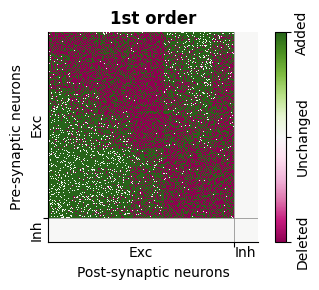

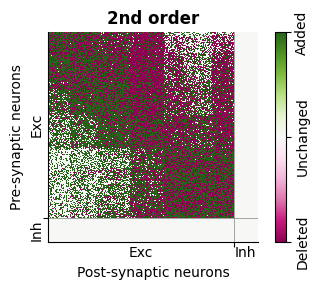

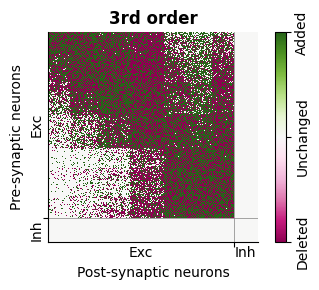

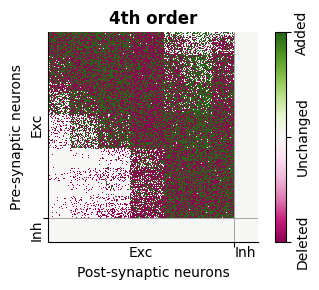

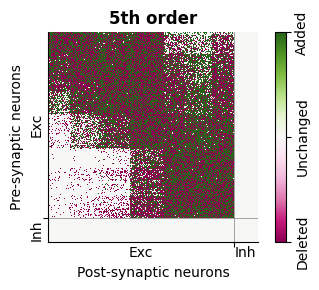

In [88]:
# Plot adjacency difference
sub_pct = 10  # Subsampled percentage of connections to display
cmap = 'PiYG'

def get_COO_data(mat):
    """Returns (non-empty) matrix elements in COOrdinate format (row/col/data)"""
    mat = mat.tocoo()
    return mat.row, mat.col, mat.data

for adj_diff, order in zip(adj_diffs, order_list):
    rows, cols, color_idx = get_COO_data(adj_diff)

    plt.figure(figsize=(4, 3))
    sub_sel = np.random.choice(len(color_idx), np.round(len(color_idx) * sub_pct / 100).astype(int), replace=False)
    plt.scatter(cols[sub_sel], rows[sub_sel], marker=',', s=0.5 / sub_pct, edgecolors='none', alpha=1.0, c=color_idx[sub_sel], cmap=cmap, vmin=-1, vmax=1, clip_on=False)
    plt.axis('image')
    plt.xlim(-0.5, adj_diff.shape[1] - 0.5)
    plt.ylim(-0.5, adj_diff.shape[0] - 0.5)
    plt.gca().invert_yaxis()
    plt.gca().set_facecolor(plt.colormaps[cmap](0.5))  # Set background to middle of colormap

    grid_loc = len(nids_exc) - 0.5
    plt.xticks([grid_loc], labels=[], minor=False)
    plt.yticks([grid_loc], labels=[], minor=False)
    plt.plot(plt.xlim(), np.full(2, grid_loc), '-', color='grey', lw=0.5, zorder=0)
    plt.plot(np.full(2, grid_loc), plt.ylim(), '-', color='grey', lw=0.5, zorder=0)

    EI_ticks = [len(nids_exc) / 2 - 0.5, len(nids_exc) + len(nids_inh) / 2 - 0.5]
    plt.xticks(EI_ticks, labels=['Exc', 'Inh'], minor=True)
    plt.yticks(EI_ticks, labels=['Exc', 'Inh'], rotation=90, va='center', minor=True)
    plt.gca().tick_params(which='minor', length=0)

    plt.xlabel('Post-synaptic neurons')
    plt.ylabel('Pre-synaptic neurons')
    plt.title(f'{ordinal_nr(order)} order', fontweight='bold')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    h_cb = plt.colorbar()
    h_cb.set_ticks([-1, 0, 1], labels=['Deleted', 'Unchanged', 'Added'], rotation=90, va='center')

    plt.tight_layout()
    if figs_path is not None:
        plt.savefig(os.path.join(figs_path, f'adj_diff_order{order}_subpct{sub_pct}.png'), dpi=600)
        # HUGE FILE SIZE # plt.savefig(os.path.join(figs_path, f'adj_diff_order{order}_subpct{sub_pct}.svg'), dpi=600)
    plt.show()


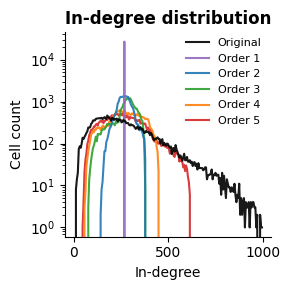

In [116]:
# In-degree distributions
plot_names = ['Original'] + [f'Order {_ord}' for _ord in order_list]
bin_size = 5
bins = np.arange(0, 1000, bin_size)

_esel = nclass_all['synapse_class'].to_numpy()[sort_idx] == 'EXC'

plt.figure(figsize=(3, 3))
for ci, cn in enumerate(plot_names):
    in_deg = np.array(np.sum(adj_mats[ci][:, _esel][_esel, :], 0)).flatten()
    counts, _ = np.histogram(in_deg, bins=bins, density=False)
    plt.plot(bins[:-1] + 0.5 * bin_size, counts, '-', label=cn, color=ORDER_COLORS[ci], alpha=0.9, zorder=len(plot_names) - ci)
plt.yscale('log')
plt.xlabel('In-degree')
plt.ylabel('Cell count')
plt.title('In-degree distribution', fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=[1.0, 1.02], fontsize=8, ncols=1, frameon=False)
# plt.yticks([])
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'struct_comp__in_degree.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'struct_comp__in_degree.svg'), dpi=600)
plt.show()


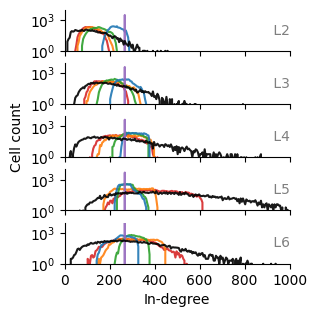

In [117]:
# EXC in-degree distributions by layer
plot_names = ['Original'] + [f'Order {_ord}' for _ord in order_list]
bin_size = 5
bins = np.arange(0, 1000, bin_size)

lay_sel = [2, 3, 4, 5, 6]

plt.figure(figsize=(3, 3))
for _idx, _lay in enumerate(lay_sel):
    _esel = nclass_all['synapse_class'].to_numpy()[sort_idx] == 'EXC'
    _lsel = nclass_all['layer'].to_numpy()[sort_idx] == _lay
    _elsel = np.logical_and(_esel, _lsel)
    plt.subplot(len(lay_sel), 1, _idx + 1)
    for ci, cn in enumerate(plot_names):
        in_deg = np.array(np.sum(adj_mats[ci][:, _elsel][_esel, :], 0)).flatten()
        counts, _ = np.histogram(in_deg, bins=bins, density=False)
        plt.plot(bins[:-1] + 0.5 * bin_size, counts, '-', label=cn, color=ORDER_COLORS[ci], alpha=0.9, zorder=len(plot_names) - ci)
    plt.yscale('log')
    plt.ylim([1, 10000])
    plt.xlim([0, 1000])
    if _idx < len(lay_sel) - 1:
        plt.gca().set_xticklabels([])
    else:
        plt.xlabel('In-degree')
    if _idx == (len(lay_sel) - 1) / 2:
        plt.ylabel('Cell count')
    # plt.title('In-degree distribution', fontweight='bold')
    # plt.legend(loc='upper right', bbox_to_anchor=[1.0, 1.02], fontsize=8, ncols=1, frameon=False)
    # plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.text(np.max(plt.xlim()), 0.01 * np.max(plt.ylim()), f' L{_lay}', ha='right', va='center', color='tab:grey')
plt.tight_layout(pad=0.1)
if figs_path is not None:
    plt.savefig(os.path.join(figs_path, f'struct_comp__in_degree_by_layer.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'struct_comp__in_degree_by_layer.svg'), dpi=600)
plt.show()


#### Connection probabilities by layer & m-type

In [118]:
# Structural comparison by layer
struct_files = [os.path.join(struct_path, 'Orig_ConnPerLayer_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-1_ConnPerLayer_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-2_ConnPerLayer_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-3_ConnPerLayer_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-4_ConnPerLayer_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-5_ConnPerLayer_Hex0EE.pickle')]
plot_names = ['Original',
              '1st order',
              '2nd order',
              '3rd order',
              '4th order',
              '5th order']

In [119]:
# Load results for structural comparison
res_dicts = []
for fn in struct_files:
    with open(fn, 'rb') as f:
        res_dict = pickle.load(f)
    # mask = res_dict['conn_prob']['data'] == 0.0  # For plotting, set pathways with conn. prob. 0.0 to NaN
    # rm_zeros(res_dict, mask)
    res_dicts.append(res_dict)

Conn. prob. (%) data range: [0.000, 2.481]
Conn. prob. (%) plot range: [0.000, 3.000]


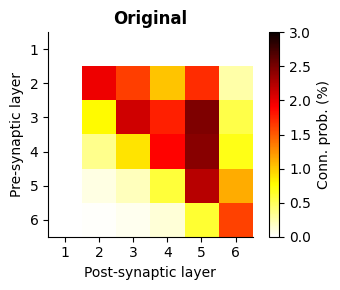

Conn. prob. (%) data range: [0.000, 1.007]
Conn. prob. (%) plot range: [0.000, 3.000]


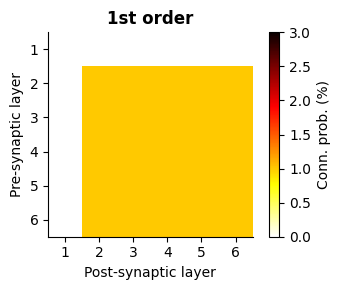

Conn. prob. (%) data range: [0.000, 3.015]
Conn. prob. (%) plot range: [0.000, 3.000]


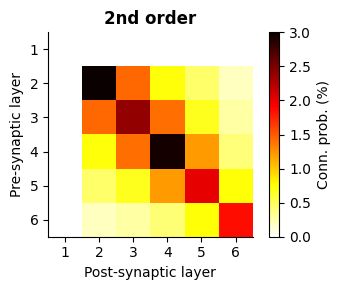

Conn. prob. (%) data range: [0.000, 3.008]
Conn. prob. (%) plot range: [0.000, 3.000]


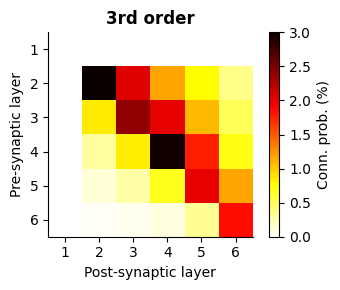

Conn. prob. (%) data range: [0.000, 2.344]
Conn. prob. (%) plot range: [0.000, 3.000]


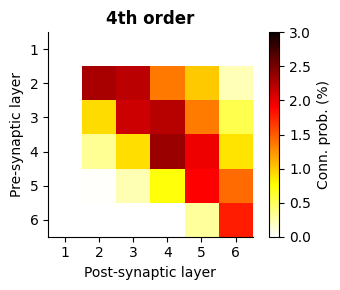

Conn. prob. (%) data range: [0.000, 2.467]
Conn. prob. (%) plot range: [0.000, 3.000]


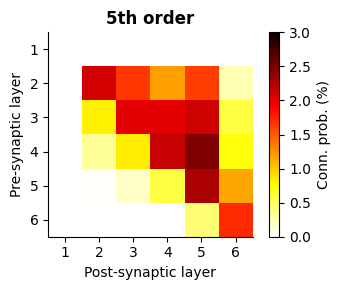

In [94]:
# Plot connection probability by layer
cmaps = ['hot_r'] * 6  # Redefine color map
plot_range_prob = [0, 3.0]
plot_range_nsyn = [0, 7.0]
# cmaps = ['hot_r'] * len(res_dicts)
for _idx in range(len(res_dicts)):
    plot_struct_res(res_dicts[_idx], 'conn_prob', plot_names[_idx], 'layer', plot_range=plot_range_prob, cmap=cmaps[_idx], colorbar=True, new_fig=True, fig_size=(4, 3), figs_path=figs_path)

Conn. prob. (%) data range: [0.000, 0.000]
Conn. prob. (%) plot range: [-1.800, 1.800]


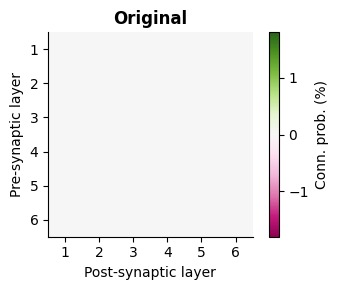

Conn. prob. (%) data range: [-1.477, 0.988]
Conn. prob. (%) plot range: [-1.800, 1.800]


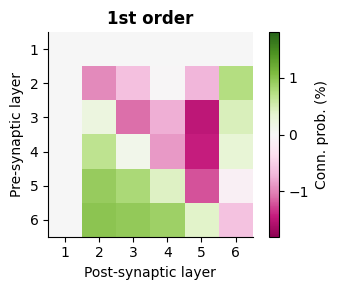

Conn. prob. (%) data range: [-1.808, 1.061]
Conn. prob. (%) plot range: [-1.800, 1.800]


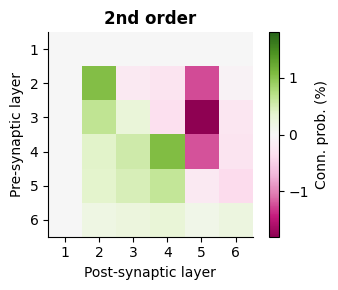

Conn. prob. (%) data range: [-1.405, 1.067]
Conn. prob. (%) plot range: [-1.800, 1.800]


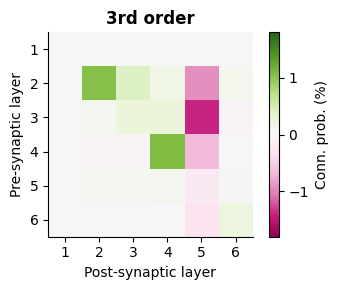

Conn. prob. (%) data range: [-1.124, 0.586]
Conn. prob. (%) plot range: [-1.800, 1.800]


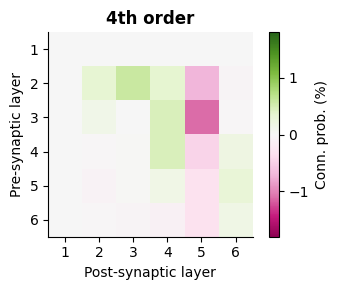

Conn. prob. (%) data range: [-0.362, 0.267]
Conn. prob. (%) plot range: [-1.800, 1.800]


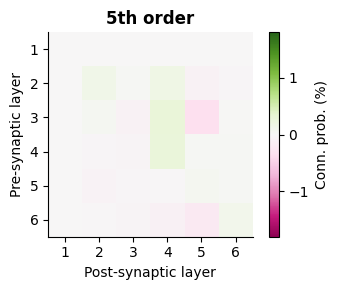

In [96]:
# Plot connection probability difference by layer
plot_range_prob = 1.8
plot_range_nsyn = 0.4
diff_cmap = 'PiYG'
for _idx in range(len(res_dicts)):
    plot_struct_res(results_diff(res_dicts[0], res_dicts[_idx]), 'conn_prob', plot_names[_idx], 'layer', plot_range=plot_range_prob, cmap=diff_cmap, colorbar=True, new_fig=True, fig_size=(4, 3), figs_path=figs_path)

In [120]:
# Structural comparison by m-type
struct_files = [os.path.join(struct_path, 'Orig_ConnPerMtype_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-1_ConnPerMtype_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-2_ConnPerMtype_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-3_ConnPerMtype_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-4_ConnPerMtype_Hex0EE.pickle'),
                os.path.join(struct_path, 'Order-5_ConnPerMtype_Hex0EE.pickle')]
plot_names = ['Original',
              '1st order',
              '2nd order',
              '3rd order',
              '4th order',
              '5th order']

In [121]:
# Load results for structural comparison
res_dicts = []
for fn in struct_files:
    with open(fn, 'rb') as f:
        res_dict = pickle.load(f)
    # mask = res_dict['conn_prob']['data'] == 0.0  # For plotting, set pathways with conn. prob. 0.0 to NaN
    # rm_zeros(res_dict, mask)
    res_dicts.append(res_dict)

Conn. prob. (%) data range: [0.000, 3.183]
Conn. prob. (%) plot range: [0.000, 3.200]


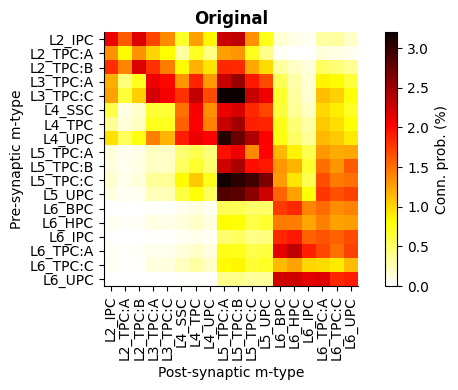

Conn. prob. (%) data range: [0.930, 1.069]
Conn. prob. (%) plot range: [0.000, 3.200]


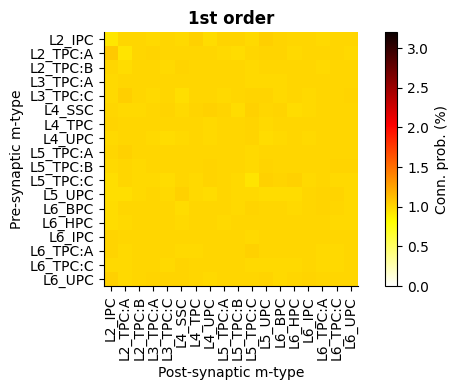

Conn. prob. (%) data range: [0.174, 3.170]
Conn. prob. (%) plot range: [0.000, 3.200]


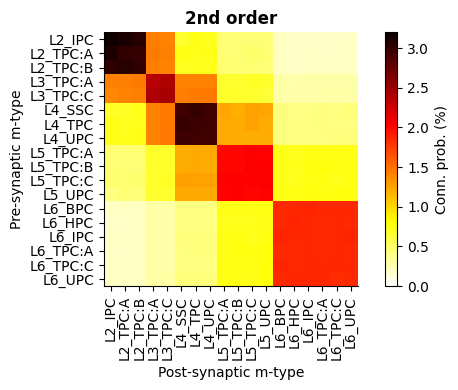

Conn. prob. (%) data range: [0.021, 3.097]
Conn. prob. (%) plot range: [0.000, 3.200]


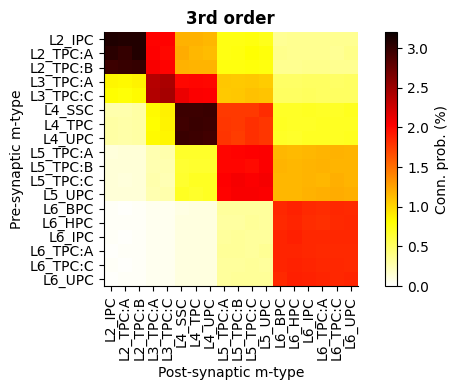

Conn. prob. (%) data range: [0.000, 2.372]
Conn. prob. (%) plot range: [0.000, 3.200]


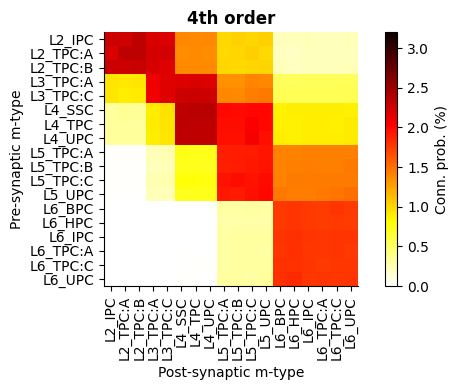

Conn. prob. (%) data range: [0.000, 2.544]
Conn. prob. (%) plot range: [0.000, 3.200]


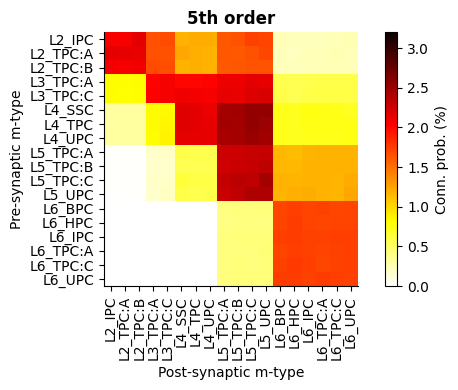

In [99]:
# Plot connection probability by m-type
plot_range_prob = [0, 3.2]
plot_range_nsyn = [0, 8.0]
# cmaps = ['hot_r'] * len(res_dicts)
for _idx in range(len(res_dicts)):
    plot_struct_res(res_dicts[_idx], 'conn_prob', plot_names[_idx], 'm-type', plot_range=plot_range_prob, cmap=cmaps[_idx], colorbar=True, new_fig=True, x_rot=True, fig_size=(6, 4), figs_path=figs_path)

Conn. prob. (%) data range: [0.000, 0.000]
Conn. prob. (%) plot range: [-2.500, 2.500]


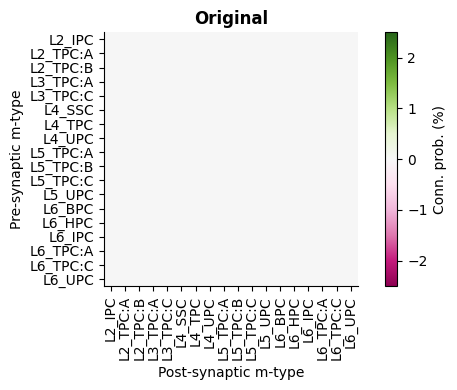

Conn. prob. (%) data range: [-2.195, 1.037]
Conn. prob. (%) plot range: [-2.500, 2.500]


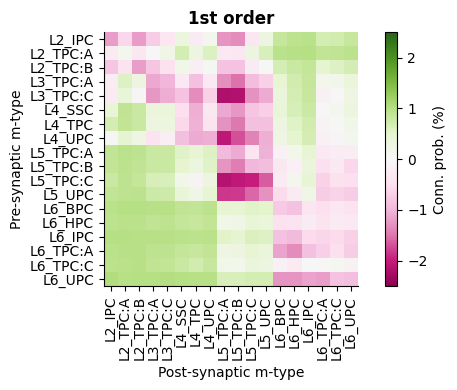

Conn. prob. (%) data range: [-2.503, 2.187]
Conn. prob. (%) plot range: [-2.500, 2.500]


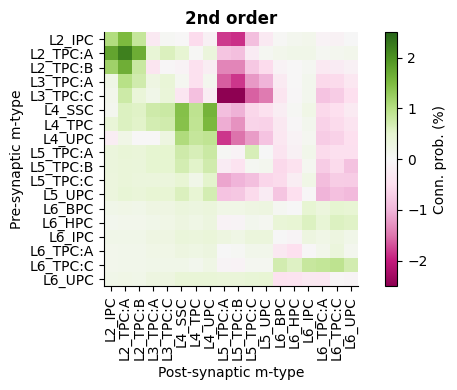

Conn. prob. (%) data range: [-2.109, 2.174]
Conn. prob. (%) plot range: [-2.500, 2.500]


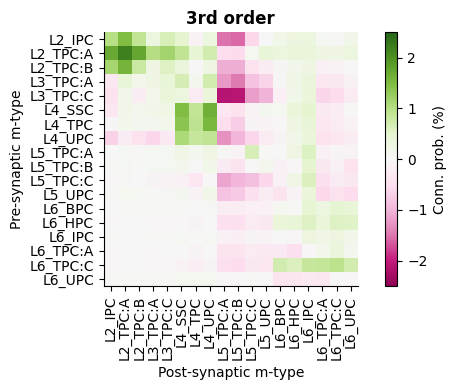

Conn. prob. (%) data range: [-1.808, 1.506]
Conn. prob. (%) plot range: [-2.500, 2.500]


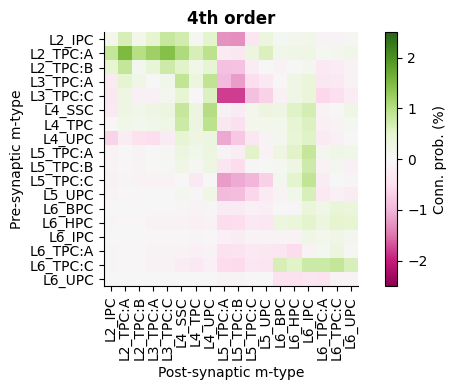

Conn. prob. (%) data range: [-1.039, 1.326]
Conn. prob. (%) plot range: [-2.500, 2.500]


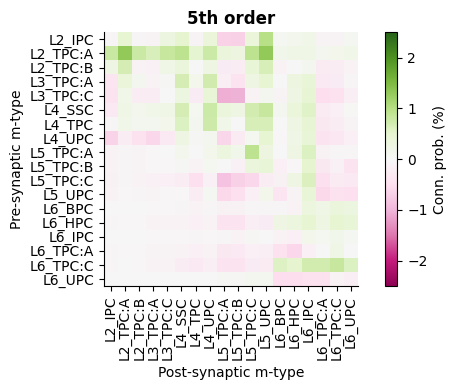

In [100]:
# Plot connection probability difference by m-type
plot_range_prob = 2.5
plot_range_nsyn = 0.6
diff_cmap = 'PiYG'
for _idx in range(len(res_dicts)):
    plot_struct_res(results_diff(res_dicts[0], res_dicts[_idx]), 'conn_prob', plot_names[_idx], 'm-type', plot_range=plot_range_prob, cmap=diff_cmap, colorbar=True, new_fig=True, x_rot=True, fig_size=(6, 4), figs_path=figs_path)

Mean #syn/conn data range: [1.538, 7.644]
Mean #syn/conn plot range: [0.000, 10.000]
324 data points


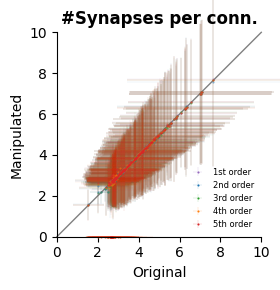

In [122]:
# nsyn/conn scatter plot
plot_struct_res_scatter(res_dicts[0], res_dicts[1:], 'nsyn_conn', '#Synapses per conn.', ['Original', 'Manipulated'], 'm-type', err_sel='nsyn_conn_std', plot_range=[0, 10], plot_specs=dict(fmt='.', alpha=0.5, lw=0.1, ms=3, markeredgecolor='none'), colors=ORDER_COLORS[1:], lgd_labels=plot_names[1:], lgd_specs=dict(frameon=False, loc='lower right', fontsize=6), new_fig=True, fig_size=(3, 3), figs_path=figs_path)

#### Physiological properties validation per m-type

In [124]:
# Structural comparison by m-type (mean/SD)
order_list = [1, 2, 3, 4, 5]
struct_files = [[os.path.join(struct_path, 'Orig_PropsPerMtype_Hex0EE.pickle'), os.path.join(struct_path, 'Orig_PropsStdPerMtype_Hex0EE.pickle')]] + \
               [[os.path.join(struct_path, f'Order-{_ord}_PropsPerMtype_Hex0EE.pickle'), os.path.join(struct_path, f'Order-{_ord}_PropsStdPerMtype_Hex0EE.pickle')] for _ord in order_list]
plot_names = ['Original'] + [f'{ordinal_nr(_ord)} order' for _ord in order_list]
props_list = ['conductance', 'decay_time', 'delay', 'depression_time', 'facilitation_time', 'n_rrp_vesicles', 'u_syn']

In [125]:
# Load results for structural comparison
res_dicts = []
for fn in struct_files:
    with open(fn[0], 'rb') as f:  # Mean
        res_dict = pickle.load(f)
    with open(fn[1], 'rb') as f:  # Std
        std_dict = pickle.load(f)
    # Add std to res_dict
    for _k in std_dict.keys():
        std_key = _k + '_std'
        assert std_key not in res_dict.keys(), f'ERROR: Key "{std_key}" already exists!'
        res_dict[std_key] = std_dict[_k]
    # mask = res_dict['conn_prob']['data'] == 0.0  # For plotting, set pathways with conn. prob. 0.0 to NaN
    # rm_zeros(res_dict, mask)
    res_dicts.append(res_dict)

Mean conductance data range: [0.190, 1.941]
Mean conductance plot range: [0.000, 3.000]
324 data points


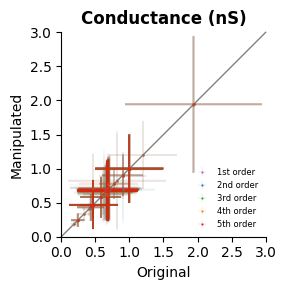

Mean decay_time data range: [1.700, 1.757]
Mean decay_time plot range: [1.600, 1.900]
324 data points


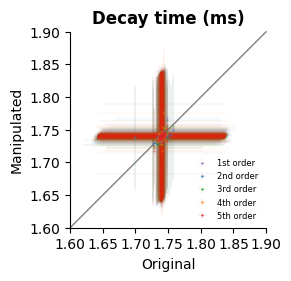

Mean delay data range: [0.881, 6.395]
Mean delay plot range: [0.000, 7.000]
324 data points


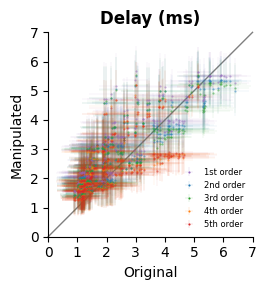

Mean depression_time data range: [279.941, 690.399]
Mean depression_time plot range: [0.000, 800.000]
324 data points


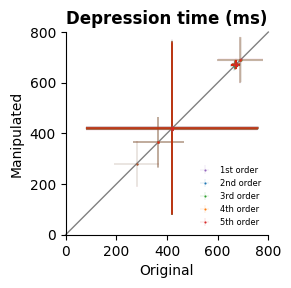

Mean facilitation_time data range: [14.423, 200.593]
Mean facilitation_time plot range: [0.000, 300.000]
324 data points


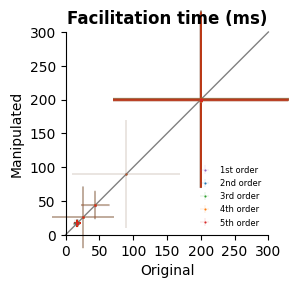

Mean n_rrp_vesicles data range: [1.000, 2.803]
Mean n_rrp_vesicles plot range: [0.000, 4.000]
324 data points


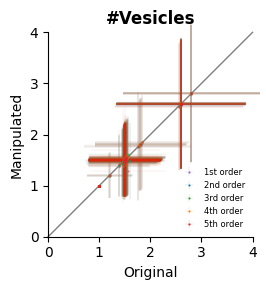

Mean u_syn data range: [0.230, 0.861]
Mean u_syn plot range: [0.000, 1.000]
324 data points


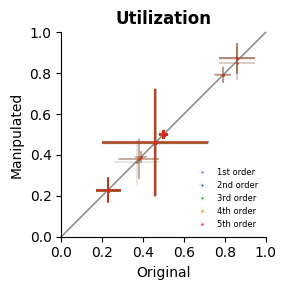

In [126]:
# Scatter plots
ax_limits = dict(conductance=[0, 3], decay_time=[1.6, 1.9], delay=[0, 7], depression_time=[0, 800], facilitation_time=[0, 300], n_rrp_vesicles=[0, 4], u_syn=[0, 1])
for _pidx, _prop in enumerate(props_list):
    plot_struct_res_scatter(res_dicts[0], res_dicts[1:], _prop, props_name_mapping[_prop], ['Original', 'Manipulated'], 'm-type', err_sel=_prop + '_std', plot_range=ax_limits[_prop], plot_specs=dict(fmt='.', alpha=0.5, lw=0.1, ms=3, markeredgecolor='none'), colors=ORDER_COLORS[1:], lgd_labels=plot_names[1:], lgd_specs=dict(frameon=False, loc='lower right', fontsize=6), new_fig=True, fig_size=(3, 3), figs_path=figs_path)